# TODO: Evaluate the impact of fixed_K for K = 10, and on the wIA models.

## Compute my own drag coefficient from SAR data

To get the average Cd on a disk, wee need to compute the expression with integrals. Use cd_mean3 for new_dsg. For K25, the disk-average Cd is simply Cd0.

I computed a K based on V (cf Foster 2009), but this doesn't really change my distribution of C_K25 compared to when I just use the average K = 50 used for the fitting.

NB: Unfortunately, when I use a reasonable scaling for K as a function of v, and inject it to compute C from C / sqrt(K), I get the correct dependance of Cd on Vmax, but a dependance of Cd on Rmax that is inversely that observed when considering Cd r v2 = cst. I think the filtering will not change anything. Note that using Cd r v2 = cst for the lower B values (i.e larger Rmax) will lead to higher Cd values in the inner-core, but is that really true?

NB: Yet, when I use my C from Cd r v2 = cst to compute K from C / sqrt(K), I obtain a K that seems to scale with vmx^2. This is actually nice! How does it compare to the KPP scheme (Is this scheme the best one in Foster) and the measurements performed by Jun A Zhang and Zhao et al 2019 (BLM)? Do the same as for my Cd: use an arbitrary function of K as a function of v, and then integrate to estimate a constant K. My fitted model needs to be consistent with that. From the literature K increases (either linearly or quadratically) with v up to 40 m/s, and then keeps increasing or saturates (depending on the reference). K is rarely above 100 m2/s, and usually around 20-50.

Assumption: See Foster 2009: KPP model with h(r). K(z) is maximal (Km) at z = h/3, we thus assume that the average value of K over z is (h * Km)/3 / h, considering that h is the boundary layer height, and thus is Km / 3. For the radial dependance, we have Km ~ Ksfc ~ h(Rmax) ~ Vm^2. So the average K should really scale with Vm^2. So do not check that further.

When I estimate K either using my own Cd or a constant one, a few values exceed 1500 m2/s, but most of them are below 1500 m2/s. It's still one order of magnitude too high, but I don't want to remove these cases as they correspond to situations when the fit is really good.

Can I estimate (C /sqrt(K), c1, c2) from (Ut, VWS, Holland params)? Do I need to impose constraints on c1 or c2 first (e.g impose c2 > 0 during the fit)?

TODO: The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

TODO: When I compare my own K estimates from K01_wINFLOW_ANGLE to the KPP estimates, I find that the KPP estimates are 2.5 to 3 times bigger than my own estimates. Maybe adjust h in my KPP formula to adjust this bias. 

NB: Sometimes, the fitting procedure yields different values when fixed_K = 50 or when fixed_K = 100. This doesn't come from the bounds on C (as the only case in K01 that reached the bound was filtered out). Instead, this comes from the cases that have a rather smooth wind field. To filter out those cases, we filter out the cases that have both max_asym_K01 == 1 (or more precisvely, < 1.1) and max_asym_sar > 2. We also add the filter that when the fitted C / sqrt(K) is too different for fixed_K = 50 and fixed_K = 100, the case is removed. Same with fixed_K = 10.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_GET_OWN_C/',
}

PRMS = {
    'sav_fgs': False,
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

640


In [4]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

### 0) Fitting diagnostic and datasets filtering

The retained filters are:

In [5]:
# dk01 = dkg01.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01.dist2coast  > dkg01.r34)             & # Distance to coast
#     (dkg01.percent_outside < 10)                & # Sufficient SAR coverage
#     (dkg01.vmx > 20)                            & # Test
#     (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
#     (dkg01.C_K01 != 0.1)                        &  # Reached the upper bound
#     (dkg01.asym_avg_err  <= 3)                     # Asymmetry is fitted
#     # (~xr.where(dkg01.non_C1 == 0, False, True))  # Ensure that I > V/r
# )

# abs(dk01.C_sqrtK_K01 - dk012.C_sqrtK_K01) > 1e-5

With the subtility that dkg01.asym_avg_err <= 3 for K01 and dkg.asym_avg_err  <= 2 for K25 (explainable because the K01 asymmetries are less consistent with SAR than the K25 ones). Also, the non-C1 filter can be a posteriori highlighted on the plots. 

Lastly, we have to include the additional filter: abs(dk01.C_sqrtK_K01 - dk012.C_sqrtK_K01) > 1e-5 and same for K25, to make sure that I don't have any fitting issue (where dk01 is with fixed_K = 50 and dk012 is with fixed_K = 100).

#### a) K01_FIT

In [6]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto50.nc'
dkg01 = xr.open_dataset(p)
dk01  = dkg01.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01.dist2coast  > dkg01.r34)             & # Distance to coast
    (dkg01.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg01.vmx > 20)                            & # Test
    (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
    (dkg01.C_K01 != 0.1)                        & # Reached the upper bound
    (dkg01.asym_avg_err  <= 3)                    # Asymmetry is fitted
    # (~xr.where(dkg01.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg01.max_asym_K01 > 1.1) | (dkg01.max_asym_sar < 2)) # Test
    # (dkg01.phase_avg_err <= 45)                 &           # Test
    # ((dkg01.storm_speed_ibt / dkg01.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01.time))
print(len(dk01.dropna(dim='time').time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

640
108


In [7]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto100.nc'
dkg01_withKsetto100 = xr.open_dataset(p)
dk01_withKsetto100  = dkg01_withKsetto100.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01_withKsetto100.dist2coast  > dkg01_withKsetto100.r34)             & # Distance to coast
    (dkg01_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg01_withKsetto100.vmx > 20)                                          & # Test
    (dkg01_withKsetto100.C_K01 != 0.0001)                                   & # Reached the lower bound
    (dkg01_withKsetto100.C_K01 != 0.1)                                      & # Reached the upper bound
    (dkg01_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg01_withKsetto100.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg01_withKsetto100.max_asym_K01 > 1.1) | (dkg01_withKsetto100.max_asym_sar <2)) # Test
    # (dkg01_withKsetto100.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01_withKsetto100.storm_speed_ibt / dkg01_withKsetto100.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01_withKsetto100.time))
print(len(dkg01_withKsetto100.dropna(dim='time').time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

640
210


In [8]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto10.nc'
dkg01_withKsetto10 = xr.open_dataset(p)
dk01_withKsetto10  = dkg01_withKsetto10.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01_withKsetto10.dist2coast  > dkg01_withKsetto10.r34)             & # Distance to coast
    (dkg01_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg01_withKsetto10.vmx > 20)                                          & # Test
    (dkg01_withKsetto10.C_K01 != 0.0001)                                   & # Reached the lower bound
    (dkg01_withKsetto10.C_K01 != 0.1)                                      & # Reached the upper bound
    (dkg01_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg01_withKsetto10.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg01_withKsetto10.max_asym_K01 > 1.1) | (dkg01_withKsetto10.max_asym_sar <2)) # Test
    # (dkg01_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01_withKsetto10.storm_speed_ibt / dkg01_withKsetto10.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01_withKsetto10.time))
print(len(dkg01_withKsetto10.dropna(dim='time').time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

640
209


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

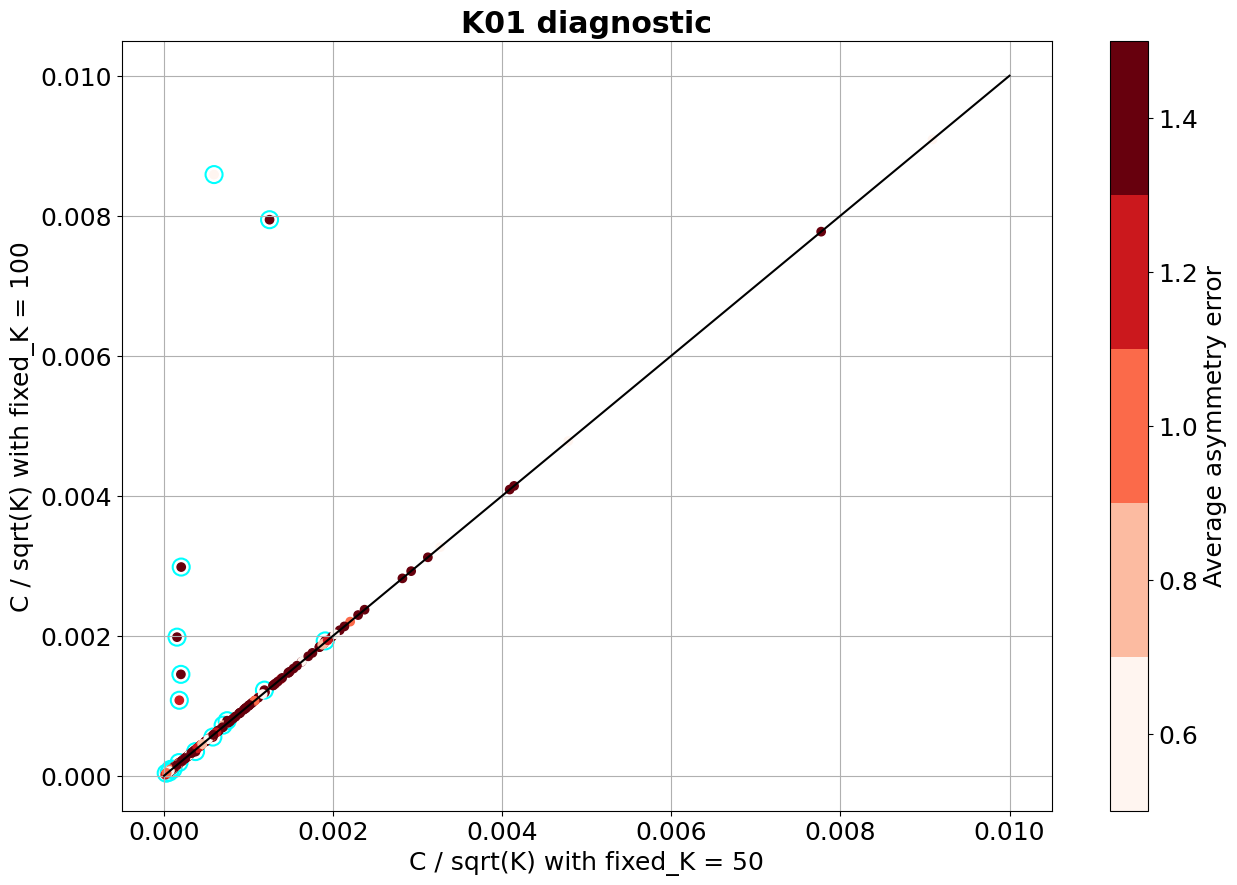

In [9]:
plt.title('K01 diagnostic', weight='bold')
msk_k01_upper = (abs(dk01.C_sqrtK_K01 - dk01_withKsetto100.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01.where(msk_k01_upper).C_sqrtK_K01, dk01_withKsetto100.where(msk_k01_upper).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01.C_sqrtK_K01, dk01_withKsetto100.C_sqrtK_K01, c=dk01.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

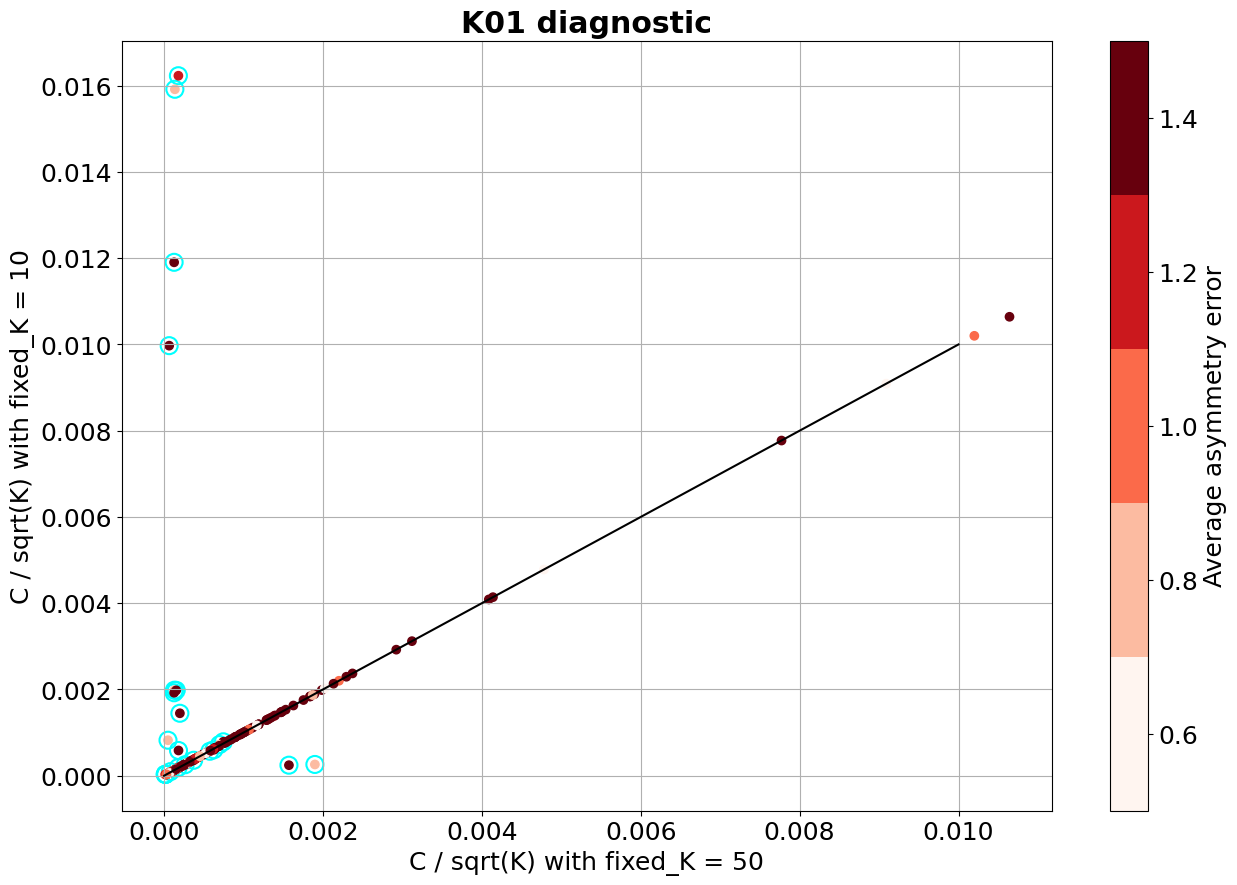

In [10]:
plt.title('K01 diagnostic', weight='bold')
msk_k01_lower = (abs(dk01.C_sqrtK_K01 - dk01_withKsetto10.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01.where(msk_k01_lower).C_sqrtK_K01, dk01_withKsetto10.where(msk_k01_lower).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01.C_sqrtK_K01, dk01_withKsetto10.C_sqrtK_K01, c=dk01.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

For ~30-50 cases, the fitting bounds for C are reached (see commented cell below). They correspond to complicated cases.

In [11]:
# a  = dkg01_withKsetto10.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01_withKsetto10.dist2coast  > dkg01_withKsetto10.r34)             & # Distance to coast
#     (dkg01_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg01_withKsetto10.C_K01 != 0.0001)                                   & # Reached the lower bound
#     # (dkg01_withKsetto10.C_K01 != 0.1)                                      & # Reached the upper bound
#     (dkg01_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(a.where(a.C_K01 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K01 < 0.00010001, drop=True).time))

# b  = dkg01_withKsetto100.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01_withKsetto100.dist2coast  > dkg01_withKsetto100.r34)             & # Distance to coast
#     (dkg01_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg01_withKsetto100.C_K01 != 0.0001)                                   & # Reached the lower bound
#     # (dkg01_withKsetto100.C_K01 != 0.1)                                      & # Reached the upper bound
#     (dkg01_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(b.where(b.C_K01 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K01 < 0.00010001, drop=True).time))

#### b) K25_FIT

In [12]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto50.nc'
dkg25 = xr.open_dataset(p)
dk25  = dkg25.where(
    # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25.dist2coast  > dkg25.r34)             & # Distance to coast
    (dkg25.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg25.vmx > 20)                            & # Test
    (dkg25.C_K25 != 0.0001)                     & # Reached the lower bound
    (dkg25.C_K25 != 0.1)                        & # Reached the upper bound
    (dkg25.asym_avg_err  <= 2)                    # Asymmetry is fitted
    # (~xr.where(dkg25.non_C1 == 0, False, True)) # Ensure that I > V/r

    # ((dkg25.max_asym_K25 > 1.1) | (dkg25.max_asym_sar < 2)) # Test
    # (dkg25.phase_avg_err <= 45)                           & # Test
    # (dkg25.C_sqrtK_K25 > 1.5e-5)                          & # Test: Reached the lower bound
    # (dkg25.C_sqrtK_K25 < 1.41e-3)                         & # Test: Reached the upper bound
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25.time))
print(len(dk25.dropna(dim='time').time))

640
107


In [13]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto100.nc'
dkg25_withKsetto100 = xr.open_dataset(p)
dk25_withKsetto100  = dkg25_withKsetto100.where(
    # (dkg25_withKsetto100.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_withKsetto100.dist2coast  > dkg25_withKsetto100.r34)             & # Distance to coast
    (dkg25_withKsetto100.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg25_withKsetto100.vmx > 20)                          & # Test
    (dkg25_withKsetto100.C_K25 != 0.0001)                   & # Reached the lower bound
    (dkg25_withKsetto100.C_K25 != 0.1)                      & # Reached the upper bound
    (dkg25_withKsetto100.asym_avg_err  <= 2)                 # Asymmetry is fitted
    # (~xr.where(dkg25_withKsetto100.non_C1 == 0, False, True)) # Ensure that I > V/r

    # ((dkg25_withKsetto100.max_asym_K25 > 1.1) | (dkg25_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg25_withKsetto100.phase_avg_err <= 45)                                         & # Test
    # (dkg25_withKsetto100.C_sqrtK_K25 > 1.5e-5)                                        & # Test: Reached the lower bound
    # (dkg25_withKsetto100.C_sqrtK_K25 < 1.41e-3)                                       & # Test: Reached the upper bound    
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25_withKsetto100.time))
print(len(dk25_withKsetto100.dropna(dim='time').time))

640
116


In [14]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto10.nc'
dkg25_withKsetto10 = xr.open_dataset(p)
dk25_withKsetto10  = dkg25_withKsetto10.where(
    # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_withKsetto10.dist2coast  > dkg25_withKsetto10.r34)             & # Distance to coast
    (dkg25_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg25_withKsetto10.vmx > 20)                                          & # Test
    (dkg25_withKsetto10.C_K25 != 0.0001)                                   & # Reached the lower bound
    (dkg25_withKsetto10.C_K25 != 0.1)                                      & # Reached the upper bound
    (dkg25_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg25_withKsetto10.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg25_withKsetto10.max_asym_K25 > 1.1) | (dkg25_withKsetto10.max_asym_sar <2)) # Test
    # (dkg25_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg25_withKsetto10.storm_speed_ibt / dkg25_withKsetto10.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25_withKsetto10.time))
print(len(dkg25_withKsetto10.dropna(dim='time').time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

640
211


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

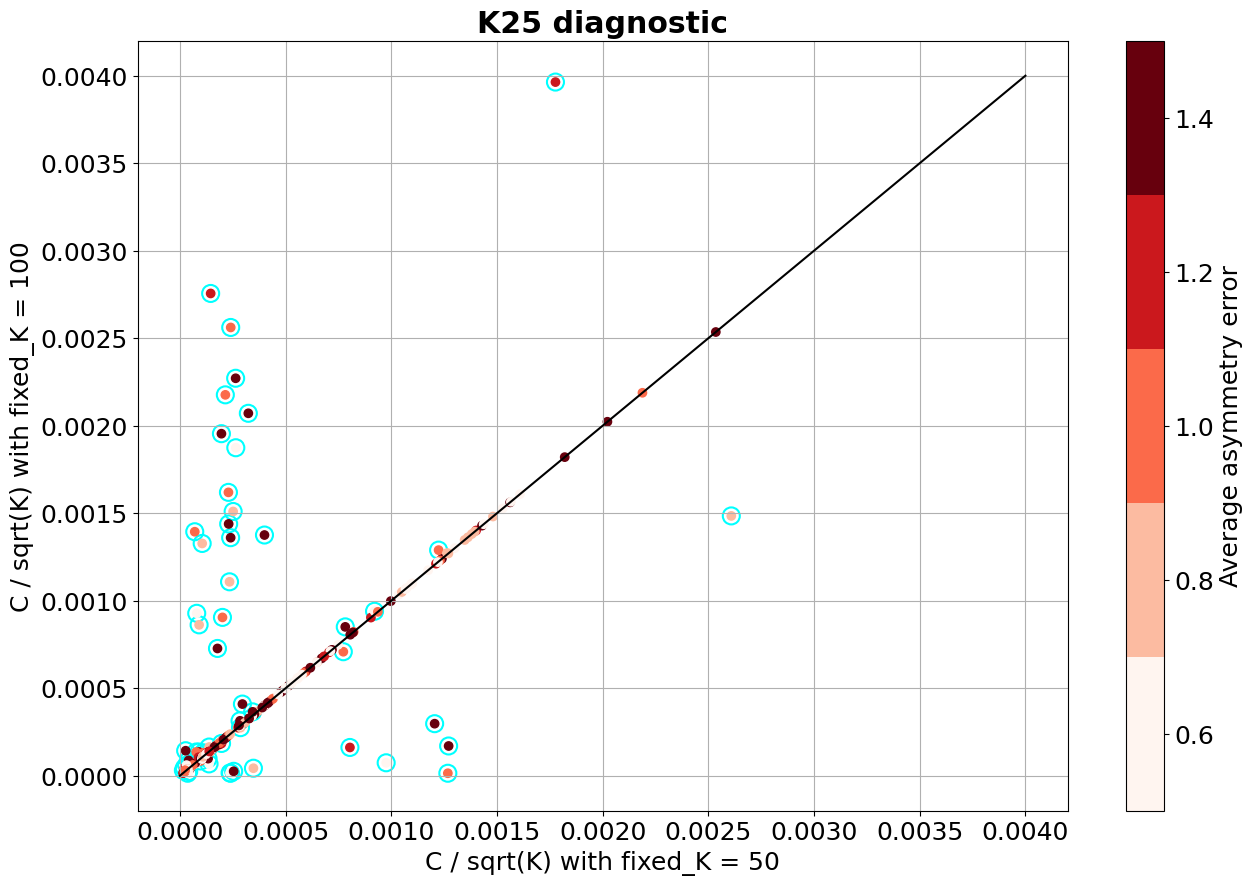

In [15]:
plt.title('K25 diagnostic', weight='bold')
msk_k25_upper = (abs(dk25.C_sqrtK_K25 - dk25_withKsetto100.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25.where(msk_k25_upper).C_sqrtK_K25, dk25_withKsetto100.where(msk_k25_upper).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25.C_sqrtK_K25, dk25_withKsetto100.C_sqrtK_K25, c=dk25.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.004], [0, 0.004], c='k')
# plt.xlim(0, 0.003)
# plt.ylim(0, 0.003)
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

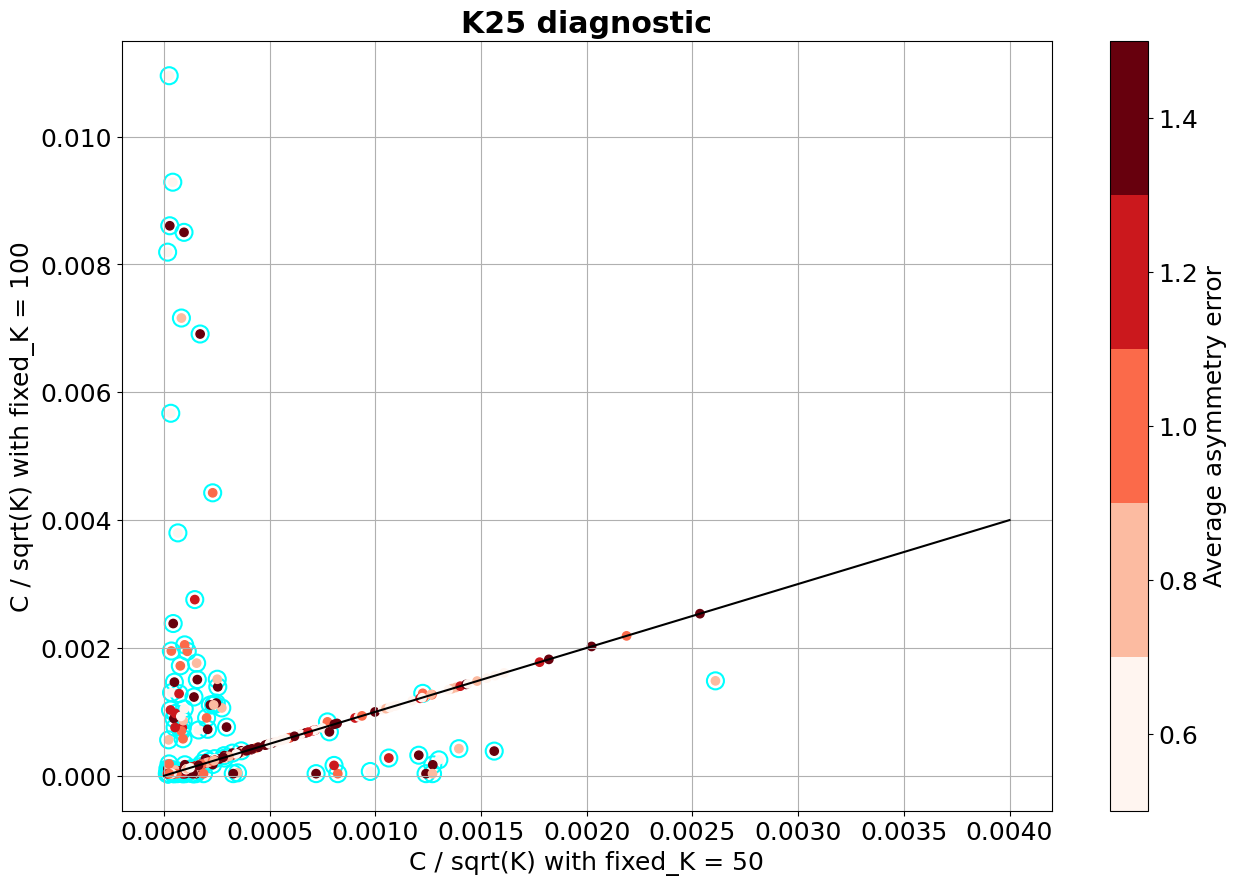

In [16]:
plt.title('K25 diagnostic', weight='bold')
msk_k25_lower = (abs(dk25.C_sqrtK_K25 - dk25_withKsetto10.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25.where(msk_k25_lower).C_sqrtK_K25, dk25_withKsetto10.where(msk_k25_lower).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25.C_sqrtK_K25, dk25_withKsetto10.C_sqrtK_K25, c=dk25.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.004], [0, 0.004], c='k')
# plt.xlim(0, 0.003)
# plt.ylim(0, 0.003)
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

The fitting bounds for C are not reached (see commented cell below).

In [17]:
# a  = dkg25_withKsetto10.where(
#     # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25_withKsetto10.dist2coast  > dkg25_withKsetto10.r34)             & # Distance to coast
#     (dkg25_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg25_withKsetto10.C_K25 != 0.0001)                                   & # Reached the lower bound
#     # (dkg25_withKsetto10.C_K25 != 0.1)                                      & # Reached the upper bound
#     (dkg25_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(a.where(a.C_K25 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K25 < 0.00010001, drop=True).time))

# b  = dkg25_withKsetto100.where(
#     # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25_withKsetto100.dist2coast  > dkg25_withKsetto100.r34)             & # Distance to coast
#     (dkg25_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg25_withKsetto100.C_K25 != 0.0001)                                   & # Reached the lower bound
#     # (dkg25_withKsetto100.C_K25 != 0.1)                                      & # Reached the upper bound
#     (dkg25_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(b.where(b.C_K25 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K25 < 0.00010001, drop=True).time))

#### c) K25_semiFit

In [18]:
### K25 SemiFit
p             = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/dsg_K25_semiFit.nc'
dkg25_semiFit = xr.open_dataset(p)
dk25_semiFit  = dkg25_semiFit.where(
    # (dkg25_semiFit.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_semiFit.dist2coast  > dkg25_semiFit.r34)     & # Distance to coast
    (dkg25_semiFit.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg25_semiFit.vmx > 20)                          & # Test
    (dkg25_semiFit.asym_avg_err  <= 2)                 # Asymmetry is fitted
    # (~xr.where(dkg25_semiFit.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # (dkg25_semiFit.phase_avg_err <= 45)               & # Test
    # (dkg25_semiFit.C_sqrtK_K25 > 1.5e-5)              & # Test: Reached the lower bound
    # (dkg25_semiFit.C_sqrtK_K25 < 1.41e-3)             & # Test: Reached the upper bound
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25_semiFit.time))
print(len(dk25_semiFit.dropna(dim='time').time))

640
122


#### d) K01_wIA

In [19]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto50.nc'
dkg01i = xr.open_dataset(p)
dk01i  = dkg01i.where(
    # (dkg01.lat > 0) &                            # Northern hemisphere; Remove this filter?
    (dkg01i.dist2coast  > dkg01i.r34)            & # Distance to coast
    (dkg01i.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg01i.vmx > 20)                            & # Test
    (dkg01i.C_K01 != 0.0001)                     & # Reached the lower bound
    (dkg01i.C_K01 != 0.1)                        & # Reached the upper bound
    (dkg01i.asym_avg_err  <= 3)                  & # Asymmetry is fitted
    (dkg01i.ratio_of_valid_scat_values > 0.9)      # Sufficient Scat coverage
    # (~xr.where(dkg01i.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg01i.max_asym_K01 > 1.1) | (dkg01.max_asym_sar < 2)) # Test
    # (dkg01i.phase_avg_err <= 45)                 &           # Test
    # ((dkg01i.storm_speed_ibt / dkg01.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i.time))
print(len(dk01i.dropna(dim='time').time))

316
77


In [20]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto100.nc'
dkg01i_withKsetto100 = xr.open_dataset(p)
dk01i_withKsetto100  = dkg01i_withKsetto100.where(
    # (dkg01_withKsetto100.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg01i_withKsetto100.dist2coast  > dkg01i_withKsetto100.r34)             & # Distance to coast
    (dkg01i_withKsetto100.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg01i_withKsetto100.vmx > 20)                                           & # Test
    (dkg01i_withKsetto100.C_K01 != 0.0001)                                    & # Reached the lower bound
    (dkg01i_withKsetto100.C_K01 != 0.1)                                       & # Reached the upper bound
    (dkg01i_withKsetto100.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                     # Sufficient Scat coverage
    # (~xr.where(dkg01i_withKsetto100.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg01i_withKsetto100.max_asym_K01 > 1.1) | (dkg01_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg01i_withKsetto100.phase_avg_err <= 45)                 &                         # Test
    # ((dkg01i_withKsetto100.storm_speed_ibt / dkg01_withKsetto100.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i_withKsetto100.time))
print(len(dk01i_withKsetto100.dropna(dim='time').time))

316
76


In [21]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto10.nc'
dkg01i_withKsetto10 = xr.open_dataset(p)
dk01i_withKsetto10  = dkg01i_withKsetto10.where(
    # (dkg01_withKsetto10.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg01i_withKsetto10.dist2coast  > dkg01i_withKsetto10.r34)              & # Distance to coast
    (dkg01i_withKsetto10.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg01i_withKsetto10.vmx > 20)                                           & # Test
    (dkg01i_withKsetto10.C_K01 != 0.0001)                                    & # Reached the lower bound
    (dkg01i_withKsetto10.C_K01 != 0.1)                                       & # Reached the upper bound
    (dkg01i_withKsetto10.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
    # (~xr.where(dkg01i_withKsetto10.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg01i_withKsetto10.max_asym_K01 > 1.1) | (dkg01_withKsetto10.max_asym_sar < 2)) # Test
    # (dkg01i_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01i_withKsetto10.storm_speed_ibt / dkg01_withKsetto10.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i_withKsetto10.time))
print(len(dk01i_withKsetto10.dropna(dim='time').time))

316
76


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

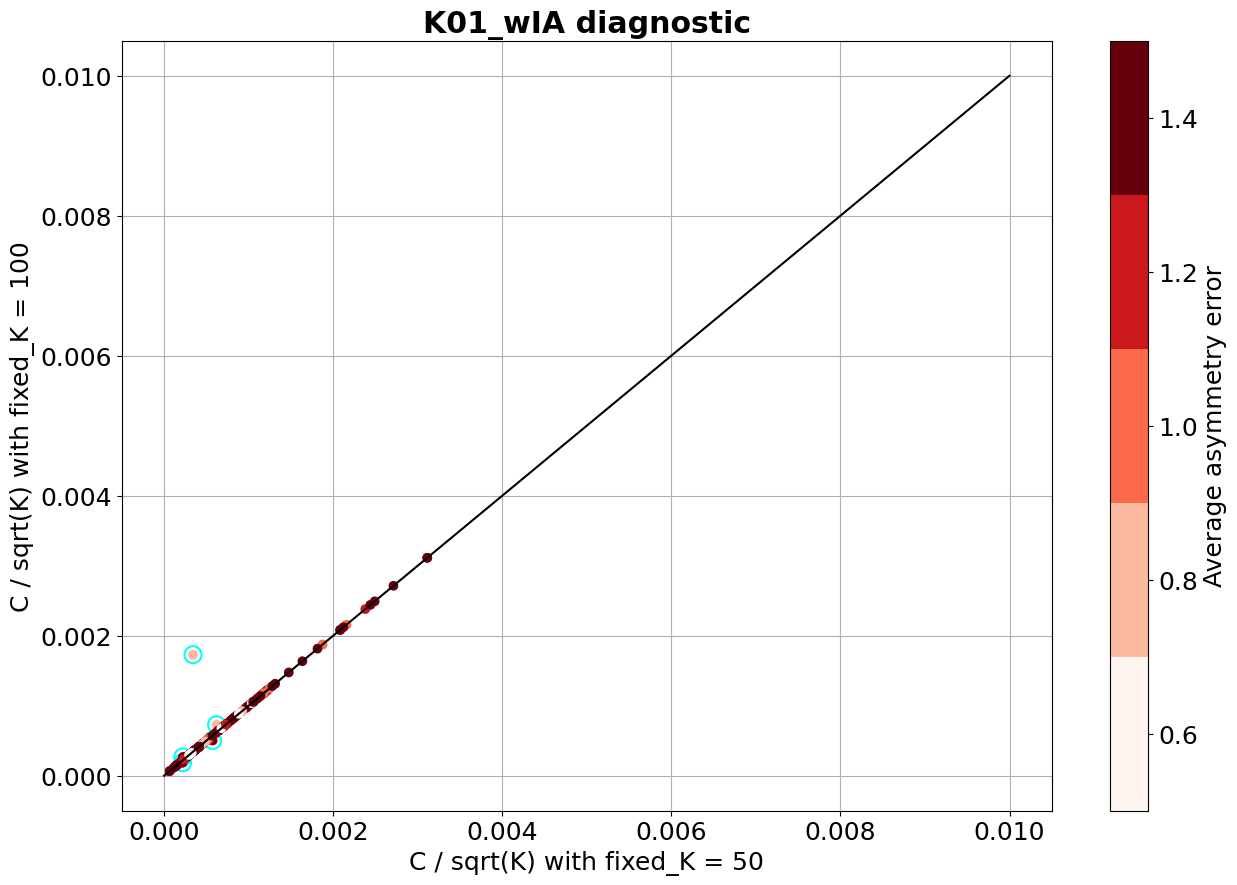

In [22]:
plt.title('K01_wIA diagnostic', weight='bold')
msk_k01i_upper = (abs(dk01i.C_sqrtK_K01 - dk01i_withKsetto100.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01i.where(msk_k01i_upper).C_sqrtK_K01, dk01i_withKsetto100.where(msk_k01i_upper).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01i.C_sqrtK_K01, dk01i_withKsetto100.C_sqrtK_K01, c=dk01i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

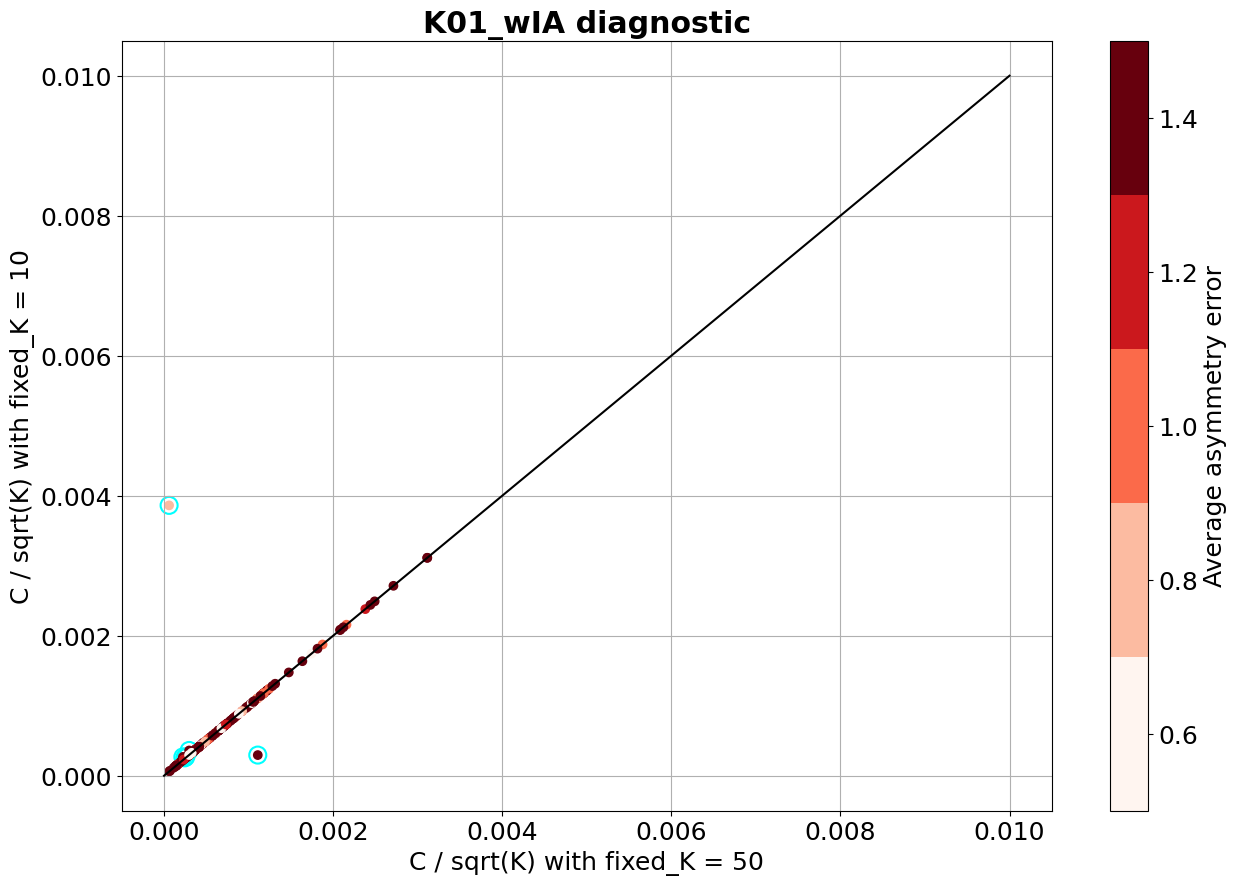

In [23]:
plt.title('K01_wIA diagnostic', weight='bold')
msk_k01i_lower = (abs(dk01i.C_sqrtK_K01 - dk01i_withKsetto10.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01i.where(msk_k01i_lower).C_sqrtK_K01, dk01i_withKsetto10.where(msk_k01i_lower).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01i.C_sqrtK_K01, dk01i_withKsetto10.C_sqrtK_K01, c=dk01i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

The fitting bounds for C are only reached for 2 cases (see commented cell below).

In [24]:
# a  = dkg01i_withKsetto10.where(
#     # (dkg01i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01i_withKsetto10.dist2coast  > dkg01i_withKsetto10.r34)             & # Distance to coast
#     (dkg01i_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01i_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg01i_withKsetto10.C_K01 != 0.0001)                                 & # Reached the lower bound
#     # (dkg01i_withKsetto10.C_K01 != 0.1)                                    & # Reached the upper bound
#     (dkg01i_withKsetto10.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                   # Sufficient Scat coverage
# )
# print(len(a.where(a.C_K01 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K01 < 0.00010001, drop=True).time))

# b  = dkg01i_withKsetto100.where(
#     # (dkg01i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01i_withKsetto100.dist2coast  > dkg01i_withKsetto100.r34)            & # Distance to coast
#     (dkg01i_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01i_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg01i_withKsetto100.C_K01 != 0.0001)                                 & # Reached the lower bound
#     # (dkg01i_withKsetto100.C_K01 != 0.1)                                    & # Reached the upper bound
#     (dkg01i_withKsetto100.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
# )
# print(len(b.where(b.C_K01 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K01 < 0.00010001, drop=True).time))

#### e) K25_wIA

In [25]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto50.nc'
dkg25i = xr.open_dataset(p)
dk25i  = dkg25i.where(
    # (dkg25.lat > 0) &                            # Northern hemisphere; Remove this filter?
    (dkg25i.dist2coast  > dkg25i.r34)            & # Distance to coast
    (dkg25i.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg25i.vmx > 20)                            & # Test
    (dkg25i.C_K25 != 0.0001)                     & # Reached the lower bound
    (dkg25i.C_K25 != 0.1)                        & # Reached the upper bound
    (dkg25i.asym_avg_err  <= 3)                  & # Asymmetry is fitted
    (dkg25i.ratio_of_valid_scat_values > 0.9)      # Sufficient Scat coverage
    # (~xr.where(dkg25i.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg25i.max_asym_K25 > 1.1) | (dkg25.max_asym_sar < 2)) # Test
    # (dkg25i.phase_avg_err <= 45)                 &           # Test
    # ((dkg25i.storm_speed_ibt / dkg25.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i.time))
print(len(dk25i.dropna(dim='time').time))

316
80


In [26]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto100.nc'
dkg25i_withKsetto100 = xr.open_dataset(p)
dk25i_withKsetto100  = dkg25i_withKsetto100.where(
    # (dkg25_withKsetto100.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg25i_withKsetto100.dist2coast  > dkg25i_withKsetto100.r34)             & # Distance to coast
    (dkg25i_withKsetto100.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg25i_withKsetto100.vmx > 20)                                           & # Test
    (dkg25i_withKsetto100.C_K25 != 0.0001)                                    & # Reached the lower bound
    (dkg25i_withKsetto100.C_K25 != 0.1)                                       & # Reached the upper bound
    (dkg25i_withKsetto100.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                     # Sufficient Scat coverage
    # (~xr.where(dkg25i_withKsetto100.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg25i_withKsetto100.max_asym_K25 > 1.1) | (dkg25_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg25i_withKsetto100.phase_avg_err <= 45)                 &                         # Test
    # ((dkg25i_withKsetto100.storm_speed_ibt / dkg25_withKsetto100.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i_withKsetto100.time))
print(len(dk25i_withKsetto100.dropna(dim='time').time))

316
78


In [27]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto10.nc'
dkg25i_withKsetto10 = xr.open_dataset(p)
dk25i_withKsetto10  = dkg25i_withKsetto10.where(
    # (dkg25_withKsetto10.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg25i_withKsetto10.dist2coast  > dkg25i_withKsetto10.r34)              & # Distance to coast
    (dkg25i_withKsetto10.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg25i_withKsetto10.vmx > 20)                                           & # Test
    (dkg25i_withKsetto10.C_K25 != 0.0001)                                    & # Reached the lower bound
    (dkg25i_withKsetto10.C_K25 != 0.1)                                       & # Reached the upper bound
    (dkg25i_withKsetto10.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
    # (~xr.where(dkg25i_withKsetto10.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg25i_withKsetto10.max_asym_K25 > 1.1) | (dkg25_withKsetto10.max_asym_sar < 2)) # Test
    # (dkg25i_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg25i_withKsetto10.storm_speed_ibt / dkg25_withKsetto10.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i_withKsetto10.time))
print(len(dk25i_withKsetto10.dropna(dim='time').time))

316
80


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

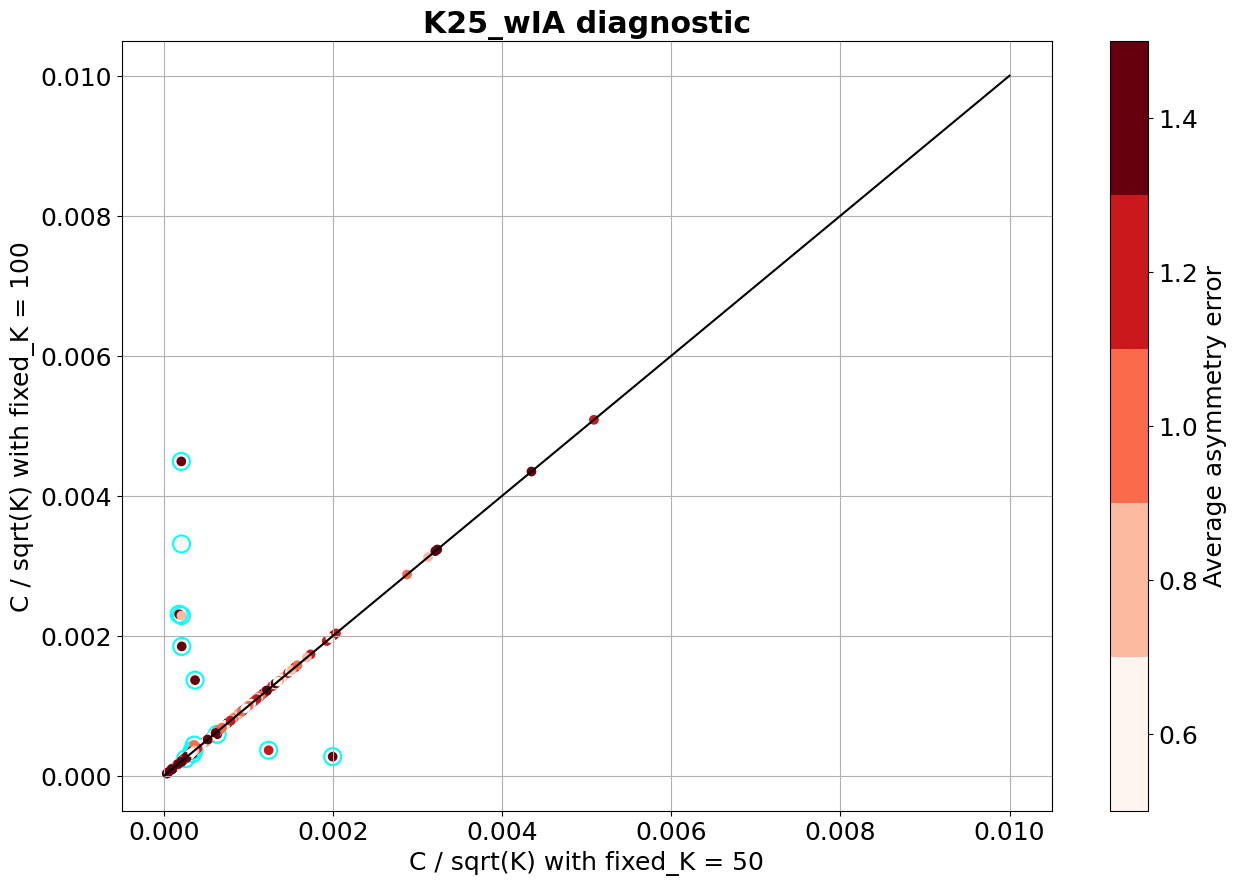

In [28]:
plt.title('K25_wIA diagnostic', weight='bold')
msk_k25i_upper = (abs(dk25i.C_sqrtK_K25 - dk25i_withKsetto100.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25i.where(msk_k25i_upper).C_sqrtK_K25, dk25i_withKsetto100.where(msk_k25i_upper).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25i.C_sqrtK_K25, dk25i_withKsetto100.C_sqrtK_K25, c=dk25i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

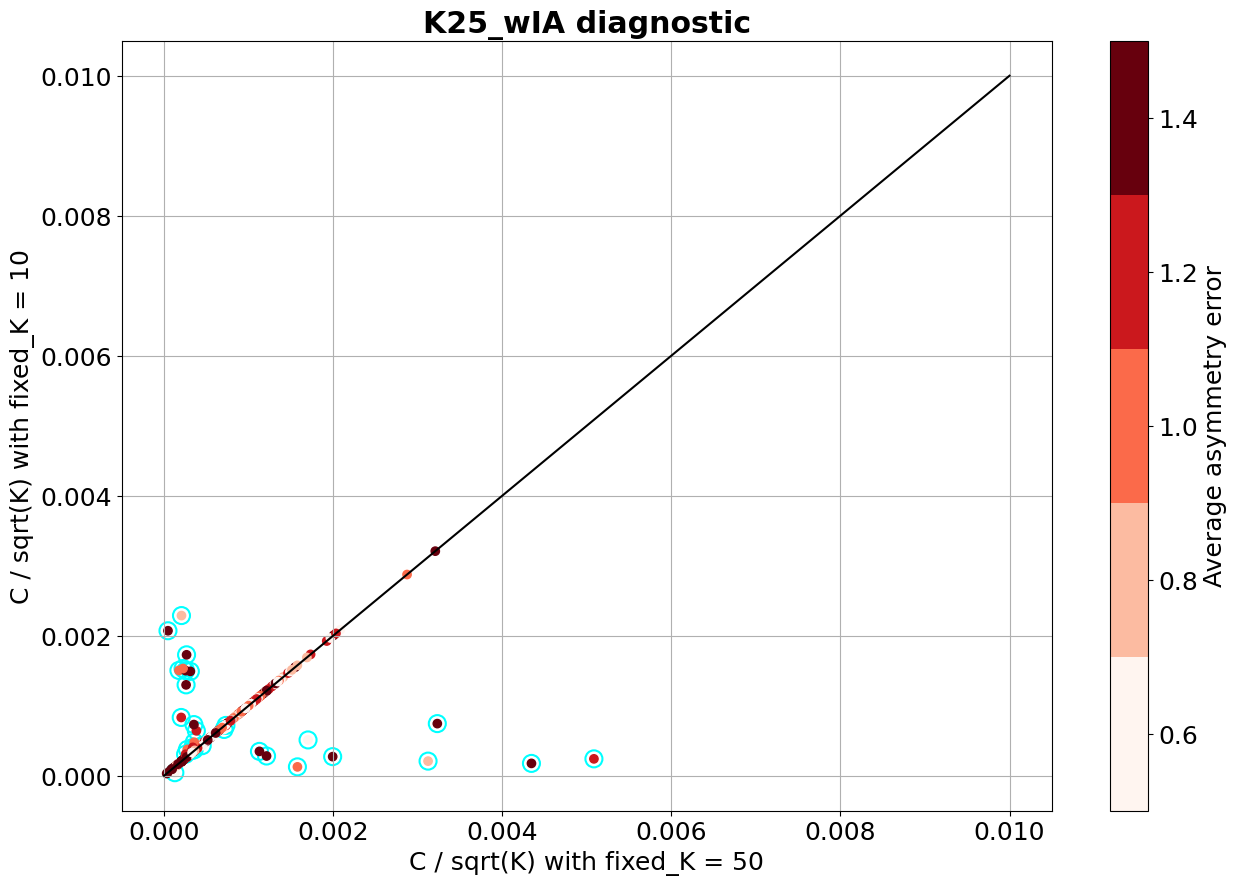

In [29]:
plt.title('K25_wIA diagnostic', weight='bold')
msk_k25i_lower = (abs(dk25i.C_sqrtK_K25 - dk25i_withKsetto10.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25i.where(msk_k25i_lower).C_sqrtK_K25, dk25i_withKsetto10.where(msk_k25i_lower).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25i.C_sqrtK_K25, dk25i_withKsetto10.C_sqrtK_K25, c=dk25i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

The fitting bounds for C are only reached for 1 case (see commented cell below).

In [30]:
# a  = dkg25i_withKsetto10.where(
#     # (dkg25i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25i_withKsetto10.dist2coast  > dkg25i_withKsetto10.r34)             & # Distance to coast
#     (dkg25i_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25i_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg25i_withKsetto10.C_K25 != 0.0001)                                 & # Reached the lower bound
#     # (dkg25i_withKsetto10.C_K25 != 0.1)                                    & # Reached the upper bound
#     (dkg25i_withKsetto10.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                   # Sufficient Scat coverage
# )
# print(len(a.where(a.C_K25 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K25 < 0.00010001, drop=True).time))

# b  = dkg25i_withKsetto100.where(
#     # (dkg25i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25i_withKsetto100.dist2coast  > dkg25i_withKsetto100.r34)            & # Distance to coast
#     (dkg25i_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25i_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg25i_withKsetto100.C_K25 != 0.0001)                                 & # Reached the lower bound
#     # (dkg25i_withKsetto100.C_K25 != 0.1)                                    & # Reached the upper bound
#     (dkg25i_withKsetto100.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
# )
# print(len(b.where(b.C_K25 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K25 < 0.00010001, drop=True).time))

#### f) Clean the datasets

In [31]:
### FILTER BOTH DATASETS
# TO ENSURE THAT FIXED_K HAS NO IMPACT
dk01_clean  = dk01.where(~msk_k01_upper & ~msk_k01_lower)
dk25_clean  = dk25.where(~msk_k25_upper & ~msk_k25_lower)
dk01i_clean = dk01i.where(~msk_k01i_upper & ~msk_k01i_lower)
dk25i_clean = dk25i.where(~msk_k25i_upper & ~msk_k25i_lower)

# TO DROP DUPLICATES FOR MULTIPLE SCAT COLLOCATIONS
dk01i_clean = dk01i_clean.where(~dk01i_clean.indexes['time'].duplicated()).dropna(dim='time')
dk25i_clean = dk25i_clean.where(~dk25i_clean.indexes['time'].duplicated()).dropna(dim='time')

### 1) Compute my own Cd and K values from all SAR data

In [32]:
### Hyperparameters
rs = np.linspace(1000, 5e5, 500)

In [230]:
# Prepare new_dsg
listOfDatasets  = []

for t in tqdm(range(len(dsg_filtered.time))):
    # Open
    ds  = dsg_filtered.isel(time=t)

    # Determined parameters
    vmx = float(ds.vmx_hol)
    rmx = float(ds.rmx_hol)
    vmn = float(ds.vmn_hol)
    B   = float(ds.B_hol)
    lat = float(ds.lat)
    fcr = abs(float(ds.fcor))
    Ut  = float(ds.speed)
    
    # Holland
    V    = holland_profile(rs, lat, B, vmn, rmx, vmx)

    # Get own Cd
    cd             = np.ones_like(V) * 1e-3 # Custom
    cd_lp          = np.ones_like(V) * 1e-3 # Large and Pond

    try:
        ### Custom
        # For r > R+
        cd[V <= 10.92] = 1.2e-3 # We use 10.92 instead of 11 to ensure continuity of Cd
        outer          = (V > 10.92) & (rs >= float(ds.rps))
        cd[outer]      = (0.49 + 0.065 * V[outer]) * 1e-3
        # For Rmax < r < R+
        cdps           = cd[rs >= float(ds.rps)][0]
        near           = (rs <= float(ds.rps)) & (rs >= float(ds.rmx))
        cd[near]       = cdps * rs[rs >= float(ds.rps)][0] * V[rs >= float(ds.rps)][0] ** 2 / (rs[near] * V[near] ** 2)

        # Average
        cd_mean1   = cd[(rs >= float(ds.rmx)) & (rs <= float(ds.r0))].mean()
        
        rmax_to_r0 = (rs >= float(ds.rmx)) & (rs <= float(ds.r0))
        # Radial integral
        cd_mean2   = np.trapz(cd[rmax_to_r0], rs[rmax_to_r0]) / float(ds.r0 - ds.rmx)
        # Cylindrical integral
        cd_mean3   = 2 * np.trapz(cd[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        ### Large and Pond formulation, averaged (cylindrical)
        # For V > 10.92 m/s
        cd_lp[V <= 10.92] = 1.2e-3 # We use 10.92 instead of 11 to ensure continuity of Cd
        low_ws            = (V > 10.92)
        cd_lp[low_ws]     = (0.49 + 0.065 * V[low_ws]) * 1e-3
        # For V > 38.62 m/s
        hgh_ws            = (V > 38.62)
        cd_lp[hgh_ws]     = 3 * 1e-3
        # Cylindrical average
        cd_mean_lp        = 2 * np.trapz(cd_lp[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        ### K
        K_mean3           = 2 * np.trapz((V[rmax_to_r0] ** 2) * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        ### K - KPP formulation, averaged (cylindrical)
        # K_kpp      = (0.25 / 12) * 0.4 * 500  * V * np.sqrt(cd_lp) + 10 * 0.4 * V * np.sqrt(cd_lp) # h = 500m
        K_kpp      = (1 / 12) * 0.4 * 1000 * V * np.sqrt(cd_lp) + 10 * 0.4 * V * np.sqrt(cd_lp) # h = 1km
        K_mean_kpp = 2 * np.trapezoid(K_kpp[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)

        if PRMS['sav_fgs']:
            plt.plot(rs / 1000, cd * 1e3)
            plt.axvline(ds.rmx / 1000, c='k', linewidth=3)
            plt.axvline(ds.rps / 1000, c='k')
            plt.axvline(ds.r0  / 1000, c='k', linestyle='dashed')
            plt.xlim(0, 250)
            plt.xlabel(r'Distance from TC center (km)')
            plt.ylabel('Average Cd (x1e-3)')
            plt.grid()
    
            # Save
            plt.savefig(PTHS['sav_dir'] + 'figs/{}.png'.format(ds.file_tcva.item()[:-17]), bbox_inches='tight', format='png');plt.clf()
        
    except IndexError:
        cd_mean1 = cd_mean2 = cd_mean3 = cd_mean_lp = K_mean_kpp = np.nan
    
    # Append
    ds['cd_mean1']   = cd_mean1
    ds['cd_mean2']   = cd_mean2
    ds['cd_mean3']   = cd_mean3
    ds['cd_mean_lp'] = cd_mean_lp
    ds['K_mean3']    = K_mean3
    ds['K_mean_kpp'] = K_mean_kpp
    listOfDatasets.append(ds)

# Concatenate
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
new_dsg = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

  0%|          | 0/640 [00:00<?, ?it/s]

/tmp/ipykernel_22503/1208912177.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cd_mean2   = np.trapz(cd[rmax_to_r0], rs[rmax_to_r0]) / float(ds.r0 - ds.rmx)
/tmp/ipykernel_22503/1208912177.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cd_mean3   = 2 * np.trapz(cd[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)
/tmp/ipykernel_22503/1208912177.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cd_mean_lp        = 2 * np.trapz(cd_lp[rmax_to_r0] * rs[rmax_to_r0], rs[rmax_to_r0]) / (float(ds.r0 - ds.rmx) ** 2)
/tmp/ipykernel_22503/1208912177.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integr

Concatenating all datasets into ds_glob. Can take a few seconds...
Concatenation ended.


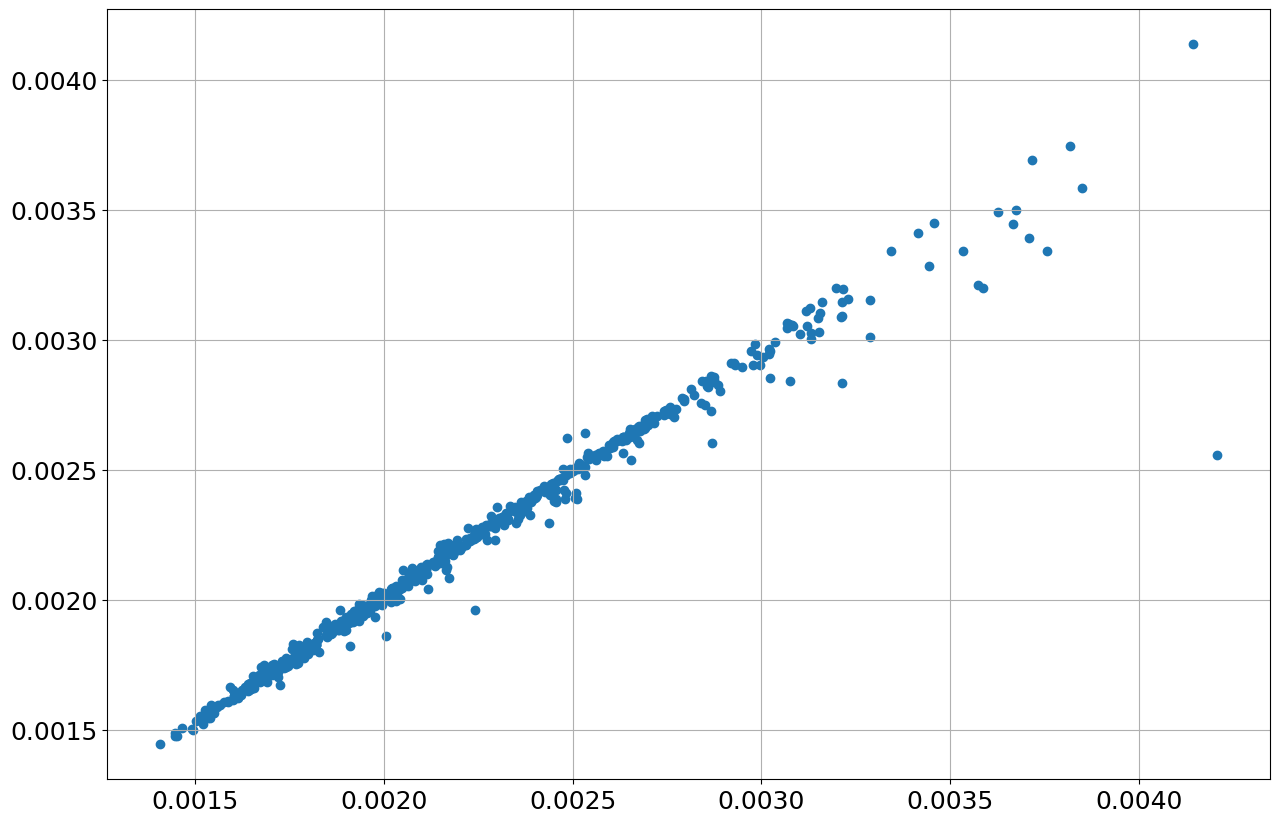

In [231]:
# Consistency between Large and Pond formulation and Cd r v2 = cst
plt.scatter(new_dsg.cd_mean3, new_dsg.cd_mean_lp)
plt.grid()

Text(0, 0.5, 'Average Cd (x1e-3)')

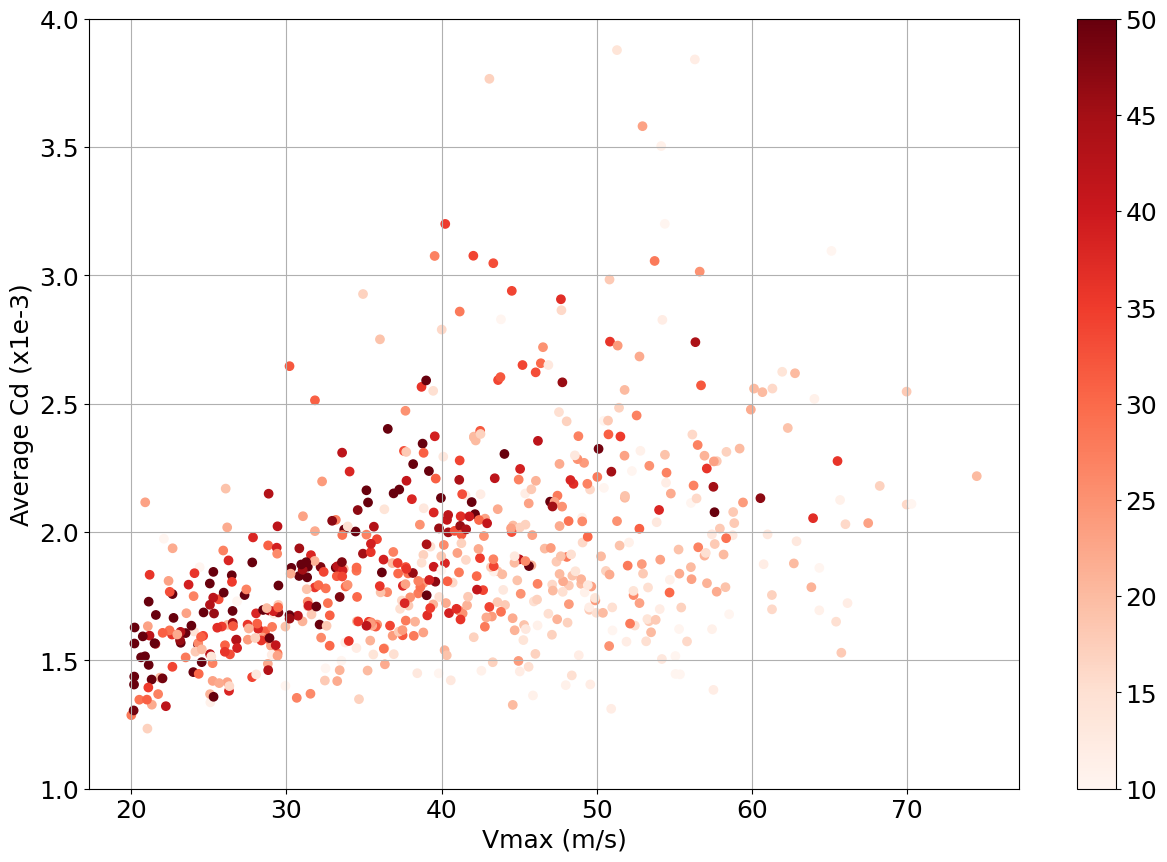

In [232]:
plt.scatter(new_dsg.vmx, new_dsg.cd_mean1 * 1e3, c=new_dsg.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

In [233]:
# plt.scatter(new_dsg.cd_mean1, new_dsg.cd_mean2)
# plt.grid()
# plt.plot([0.001, 0.006], [0.001, 0.006])

Text(0, 0.5, 'Average Cd (x1e-3)')

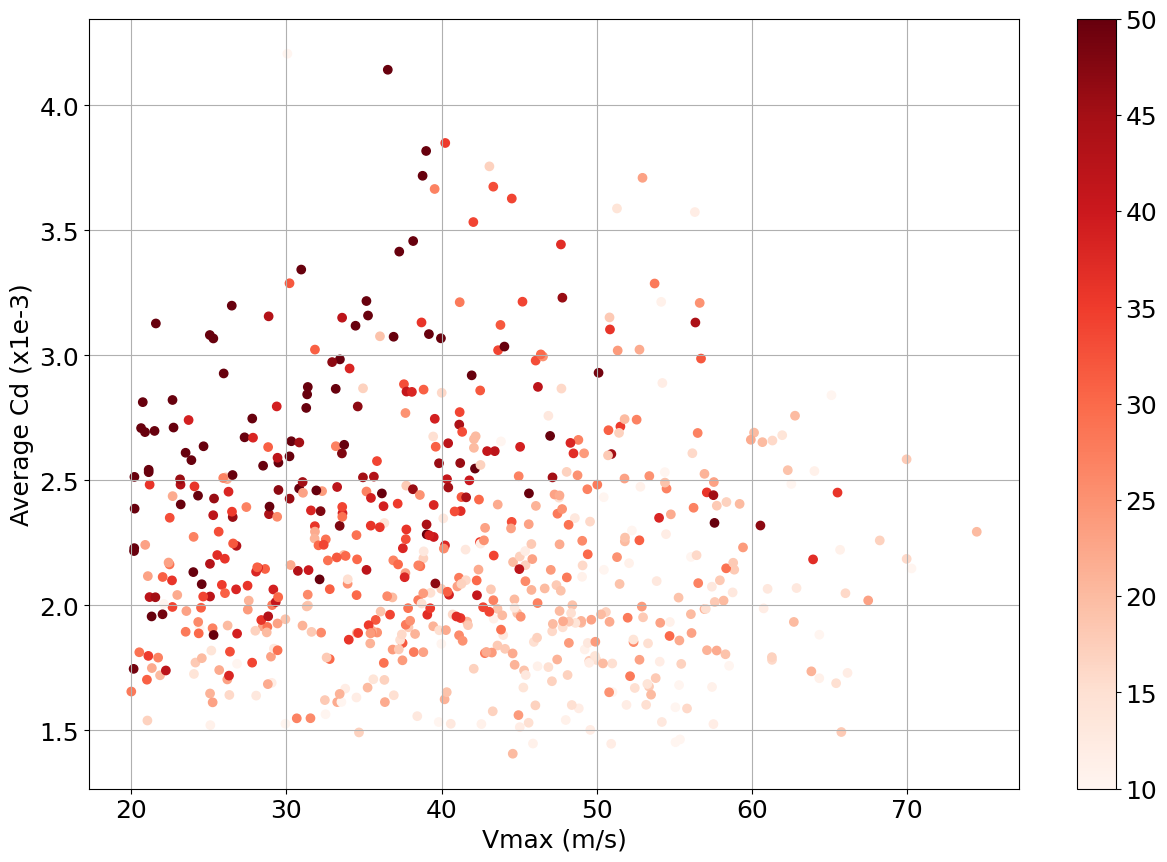

In [234]:
plt.scatter(new_dsg.vmx, new_dsg.cd_mean3 * 1e3, c=new_dsg.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
# plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

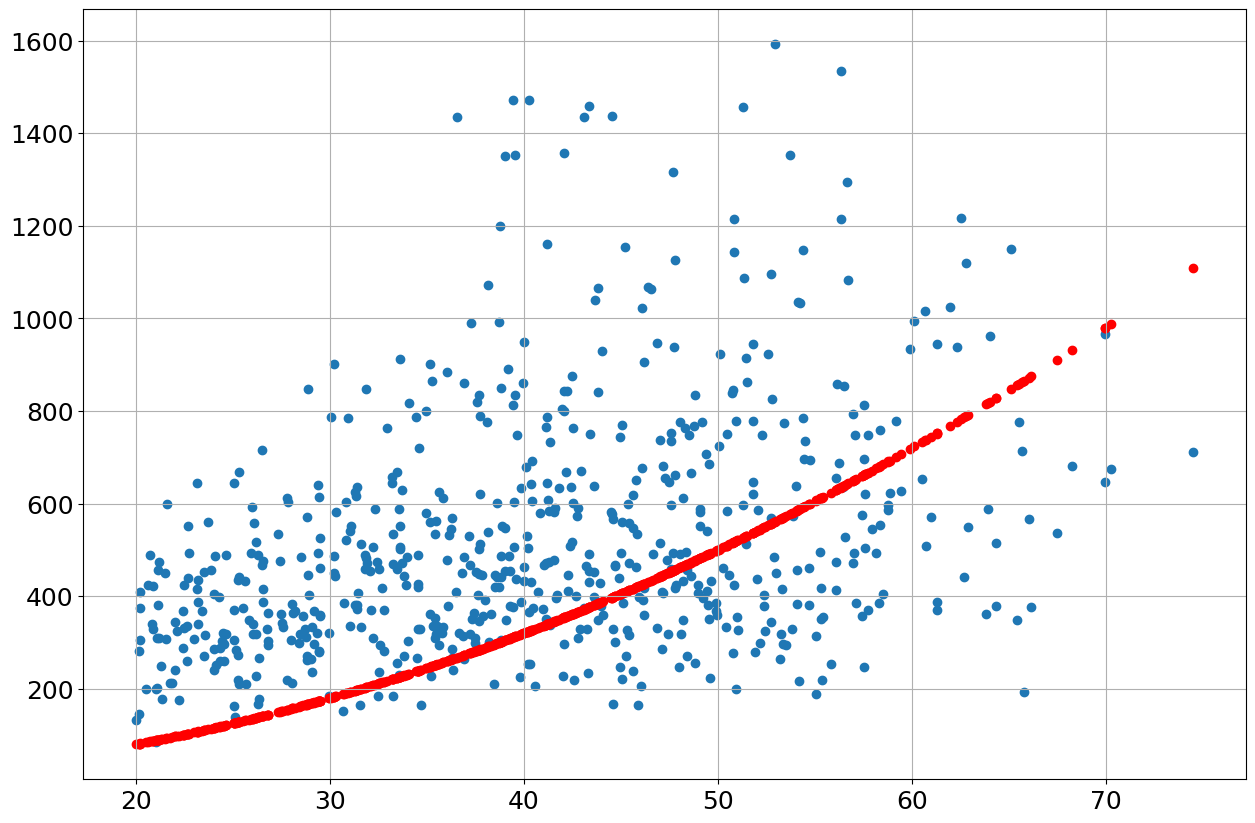

In [235]:
plt.scatter(new_dsg.vmx, new_dsg.K_mean3)
plt.scatter(new_dsg.vmx, new_dsg.vmx ** 2 / 5, color='r')
plt.grid()

### 2) Compare with model data

#### a) K25_FIT

In [236]:
dsm25_fit = xr.merge([dk25_clean,   new_dsg], join="inner", compat='override') # Fit (Clean)
dsm25_sFt = xr.merge([dk25_semiFit, new_dsg], join="inner", compat='override') # SemiFit



dsm25_fit['wght_cont']   = dsm25_fit.storm_speed_ibt * np.cos(np.deg2rad(dsm25_fit.storm_dir_ibt)) + dsm25_fit.vws_pmd * np.cos(np.deg2rad(dsm25_fit.wsd_pmd))
angles                   = (np.rad2deg(np.arctan((dsm25_fit.c1_K25 / dsm25_fit.c2_K25))) % 360).copy(deep=True)
angles_bis               = xr.where(angles >= 180, angles, angles + 360)
dsm25_fit['angles_bis']  = angles_bis

dsm25_sFt['wght_cont']  = dsm25_sFt.storm_speed_ibt * np.cos(np.deg2rad(dsm25_sFt.storm_dir_ibt)) + dsm25_sFt.vws_pmd * np.cos(np.deg2rad(dsm25_sFt.wsd_pmd))
angles                  = (np.rad2deg(np.arctan((dsm25_sFt.c1_K25 / dsm25_sFt.c2_K25))) % 360).copy(deep=True)
angles_bis              = xr.where(angles >= 180, angles, angles + 360)
dsm25_sFt['angles_bis'] = angles_bis

Text(0, 0.5, 'Average Cd (x1e-3)')

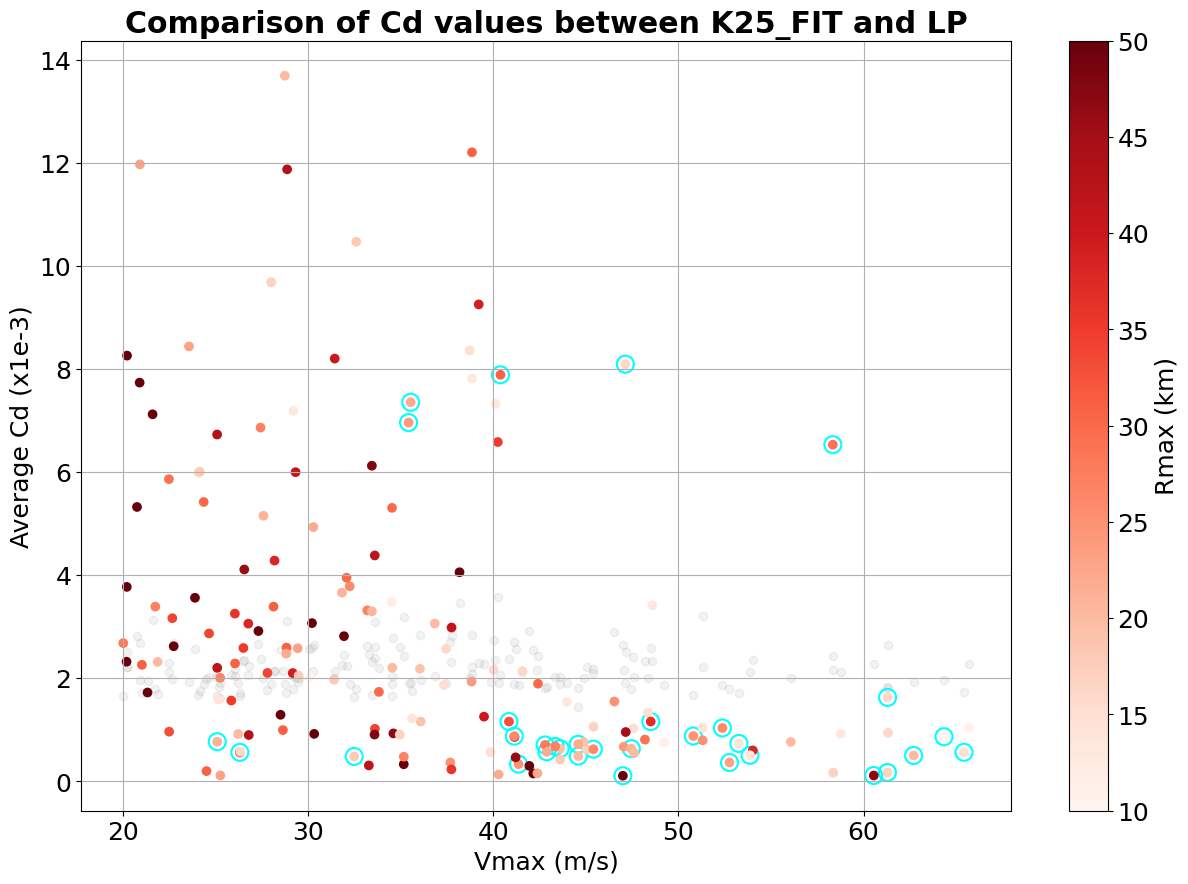

In [237]:
# In Cyan: Non-C1 points
plt.title('Comparison of Cd values between K25_FIT and LP', weight='bold')
plt.scatter(dsm25_fit.vmx, dsm25_fit.cd_mean_lp * 1e3, c='gray', alpha=0.1)
plt.scatter(dsm25_fit.where(xr.where(dsm25_fit.non_C1 == 0, False, True)).vmx, np.sqrt(dsm25_fit.where(xr.where(dsm25_fit.non_C1 == 0, False, True)).K_mean_kpp) / 1 * dsm25_fit.where(xr.where(dsm25_fit.non_C1 == 0, False, True)).C_sqrtK_K25 * 1e3, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_fit.vmx, np.sqrt(dsm25_fit.K_mean_kpp) / 1 * dsm25_fit.C_sqrtK_K25 * 1e3, c=dsm25_fit.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
# plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

Text(0, 0.5, 'Estimated K (m2/s)')

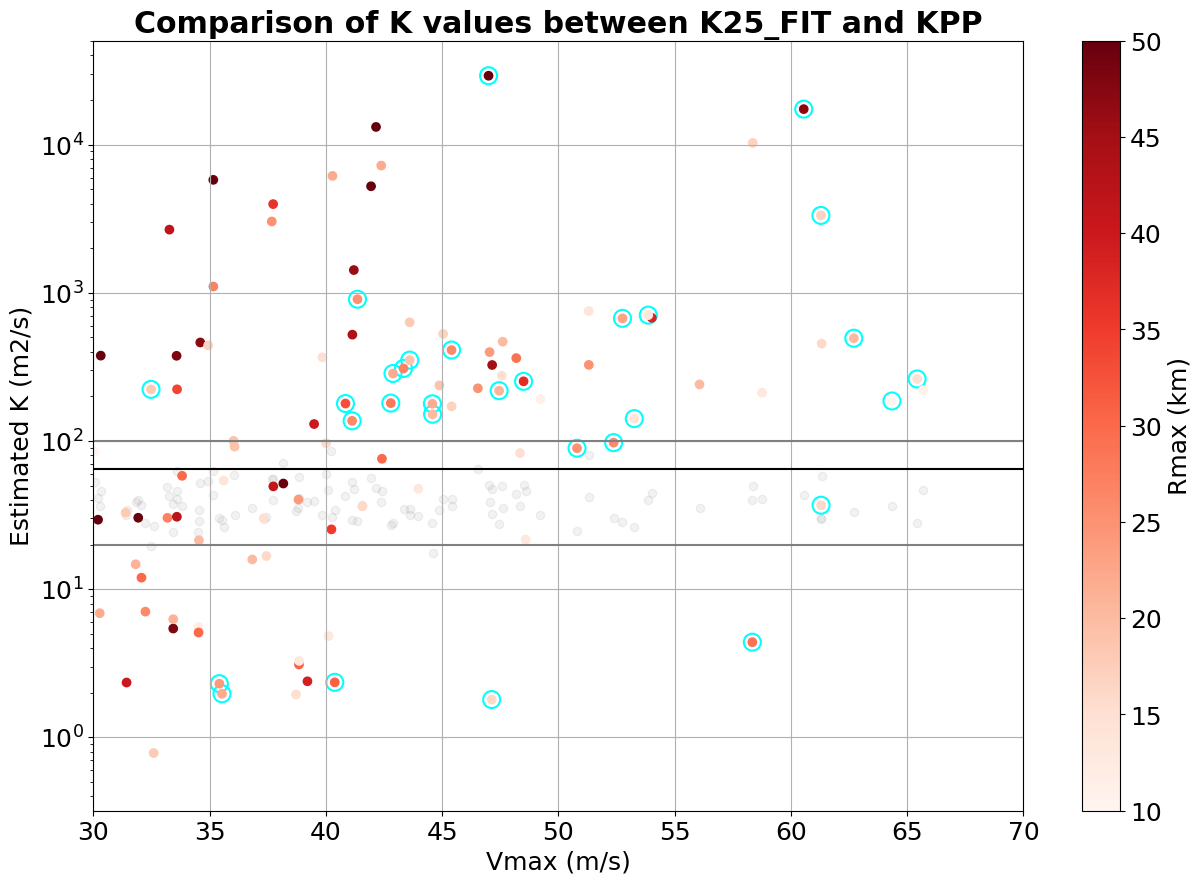

In [238]:
plt.title('Comparison of K values between K25_FIT and KPP', weight='bold')
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
plt.scatter(dsm25_fit.vmx, dsm25_fit.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm25_fit.where(xr.where(dsm25_fit.non_C1 == 0, False, True)).vmx, (dsm25_fit.where(xr.where(dsm25_fit.non_C1 == 0, False, True)).cd_mean_lp / dsm25_fit.C_sqrtK_K25) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_fit.vmx, (dsm25_fit.cd_mean_lp / dsm25_fit.C_sqrtK_K25) ** 2, c=dsm25_fit.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
# plt.ylim(-100, 4000)
plt.yscale('log')
# plt.ylim(-10, 200)
plt.xlim(30, 70)
plt.axhline(100, c='gray')
plt.axhline(65,  c='k')
plt.axhline(20,  c='gray')
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Estimated K (m2/s)')

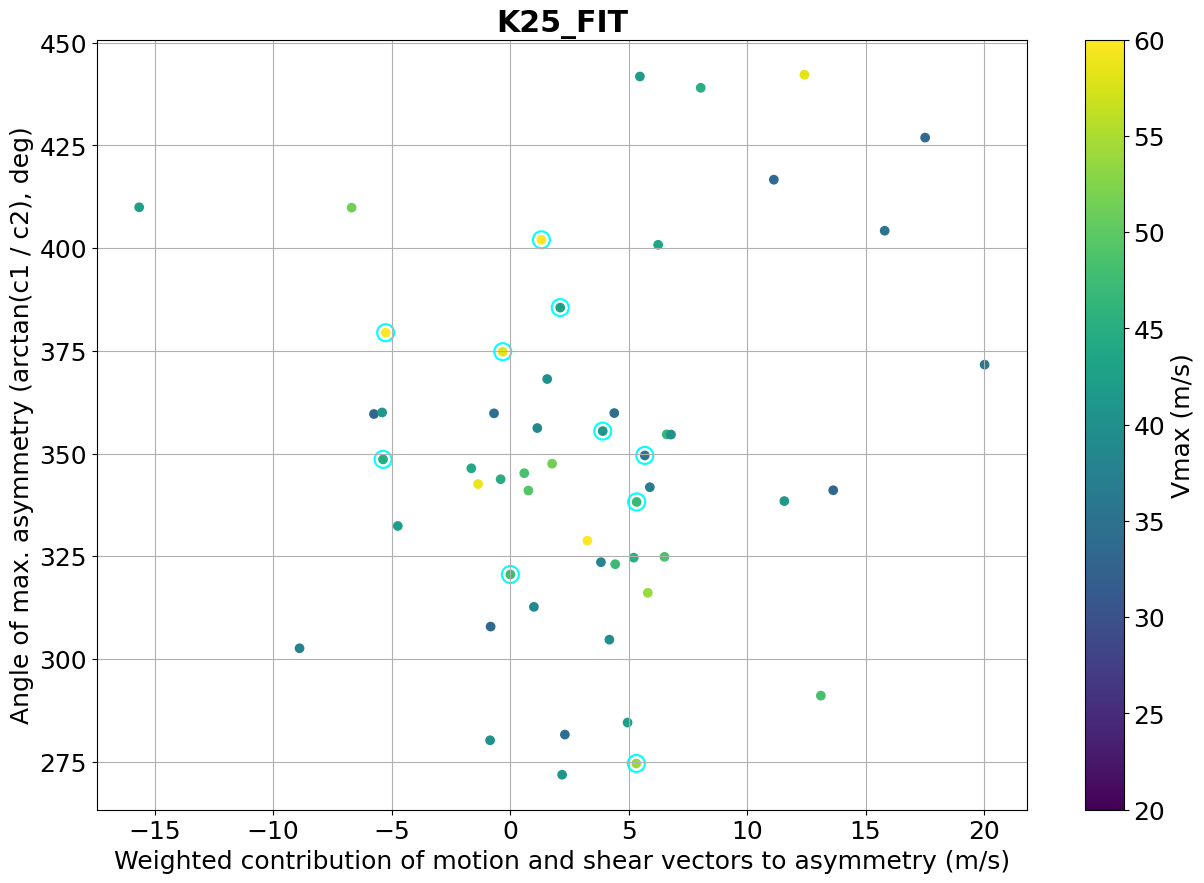

In [239]:
plt.title('K25_FIT', weight='bold')
# c1 / c2 as a function of relative contribution from shear and motion vectors
# NB: les outliers en haut semblent normaux
# NB: l'outlier tout à gauche à un Vmax très faible, proche de 20 m/s
plt.scatter(dsm25_fit.where(xr.where(dsm25_fit.non_C1 == 0, False, True)).dropna(dim='time').wght_cont, dsm25_fit.where(xr.where(dsm25_fit.non_C1 == 0, False, True)).dropna(dim='time').angles_bis, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_fit.dropna(dim='time').wght_cont, dsm25_fit.dropna(dim='time').angles_bis, c=dsm25_fit.dropna(dim='time').vmx, vmin=20, vmax=60)
plt.colorbar(label='Vmax (m/s)')
plt.xlabel('Weighted contribution of motion and shear vectors to asymmetry (m/s)')
plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
plt.grid()

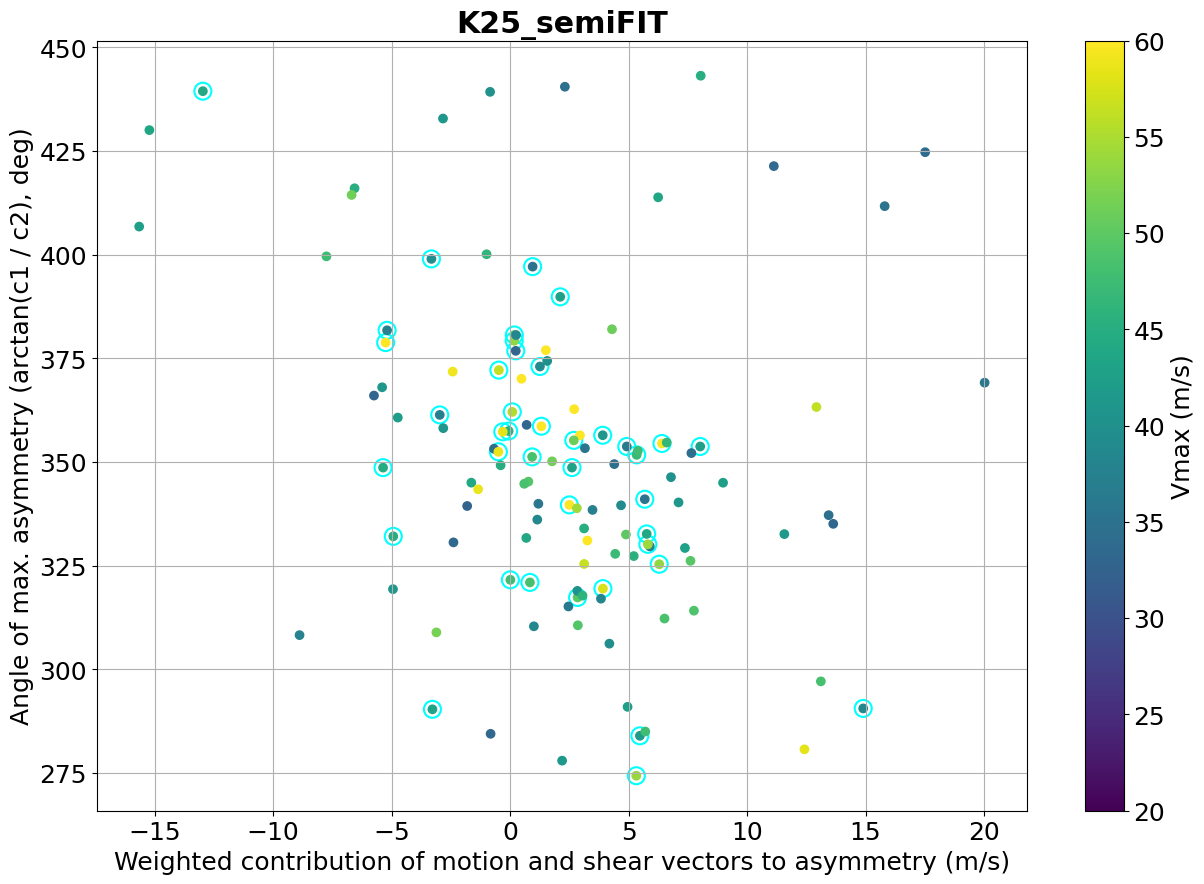

In [240]:
plt.title('K25_semiFIT', weight='bold')
# c1 / c2 as a function of relative contribution from shear and motion vectors
# NB: les outliers en haut semblent normaux
# NB: l'outlier tout à gauche à un Vmax très faible, proche de 20 m/s
plt.scatter(dsm25_sFt.where(xr.where(dsm25_sFt.non_C1 == 0, False, True)).dropna(dim='time').wght_cont, dsm25_sFt.where(xr.where(dsm25_sFt.non_C1 == 0, False, True)).dropna(dim='time').angles_bis, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_sFt.dropna(dim='time').wght_cont, dsm25_sFt.dropna(dim='time').angles_bis, c=dsm25_sFt.dropna(dim='time').vmx, vmin=20, vmax=60)
plt.colorbar(label='Vmax (m/s)')
plt.xlabel('Weighted contribution of motion and shear vectors to asymmetry (m/s)')
plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
plt.grid()

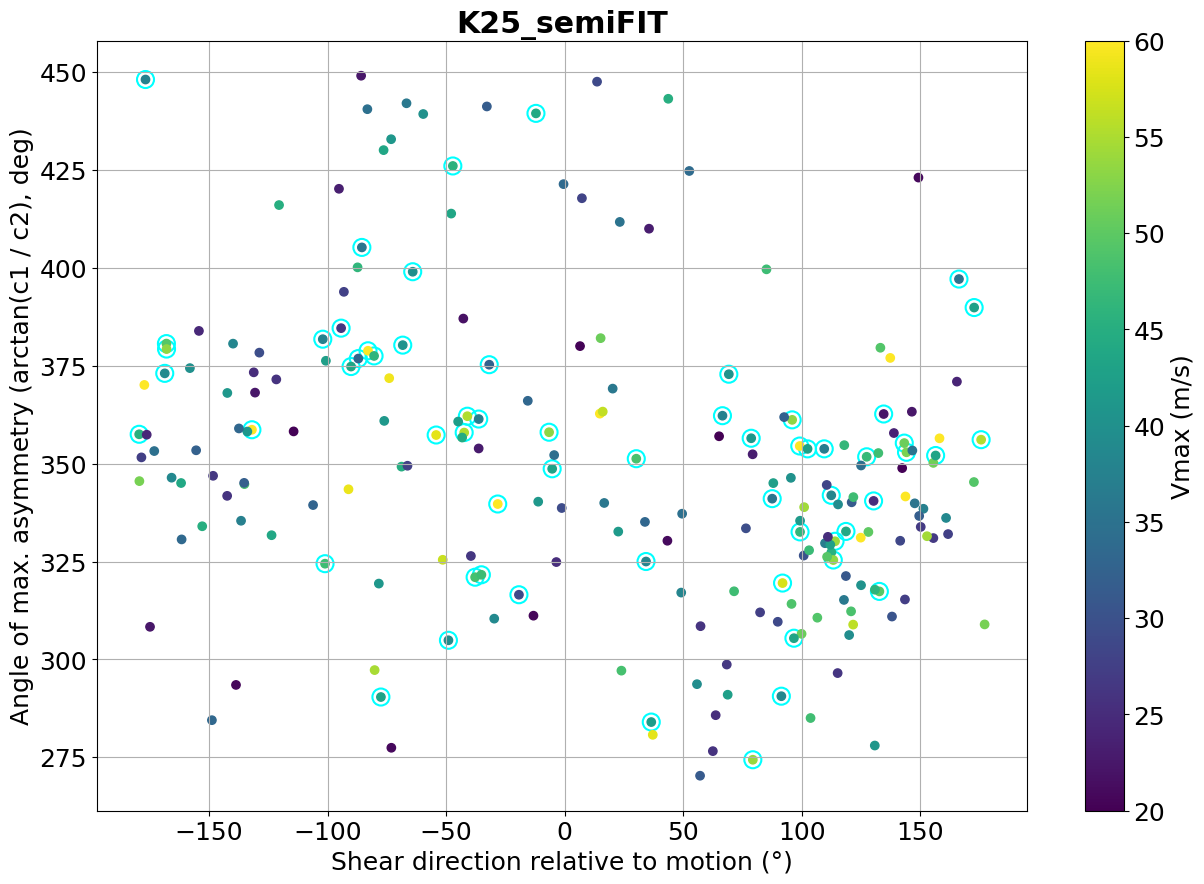

In [241]:
plt.title('K25_semiFIT', weight='bold')

keep       = (dsm25_sFt.lat > 0) & (~np.isnan(dsm25_sFt.wsd_pmd)) & (~np.isnan(dsm25_sFt.storm_dir_ibt))
x_variable = xr.where((dsm25_sFt.wsd_pmd - dsm25_sFt.storm_dir_ibt) % 360 < 180, (dsm25_sFt.wsd_pmd - dsm25_sFt.storm_dir_ibt) % 360, (dsm25_sFt.wsd_pmd - dsm25_sFt.storm_dir_ibt) % 360 - 360)

plt.scatter(x_variable.where(xr.where(dsm25_sFt.non_C1 == 0, False, True))[keep].dropna(dim='time'), dsm25_sFt.where(xr.where(dsm25_sFt.non_C1 == 0, False, True)).angles_bis[keep].dropna(dim='time'), s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(x_variable[keep].dropna(dim='time'), dsm25_sFt.angles_bis[keep].dropna(dim='time'), c=dsm25_sFt.vmx[keep].dropna(dim='time'), vmin=20, vmax=60)
plt.colorbar(label='Vmax (m/s)')
plt.xlabel('Shear direction relative to motion (°)')
plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
plt.grid()

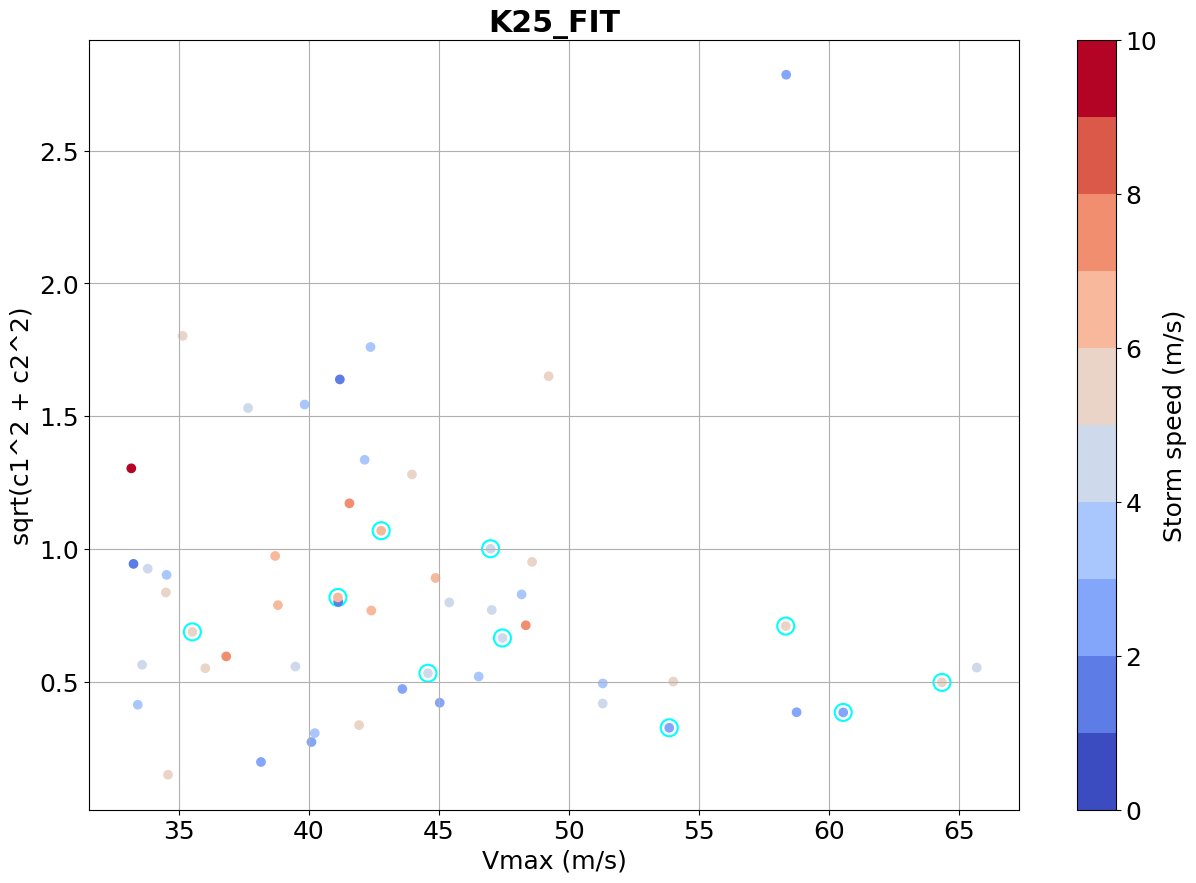

In [242]:
plt.title('K25_FIT', weight='bold')
plt.scatter(dsm25_fit.where(xr.where(dsm25_fit.non_C1 == 0, False, True)).dropna(dim='time').vmx, np.sqrt(dsm25_fit.where(xr.where(dsm25_fit.non_C1 == 0, False, True)).dropna(dim='time').c1_K25 ** 2 + dsm25_fit.where(xr.where(dsm25_sFt.non_C1 == 0, False, True)).dropna(dim='time').c2_K25 ** 2), s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_fit.dropna(dim='time').vmx, np.sqrt(dsm25_fit.dropna(dim='time').c1_K25 ** 2 + dsm25_fit.dropna(dim='time').c2_K25 ** 2), c=dsm25_fit.dropna(dim='time').speed, cmap=plt.get_cmap('coolwarm', 10), vmin=0, vmax=10)
plt.xlabel('Vmax (m/s)')
plt.ylabel('sqrt(c1^2 + c2^2)')
plt.grid()
plt.colorbar(label='Storm speed (m/s)')

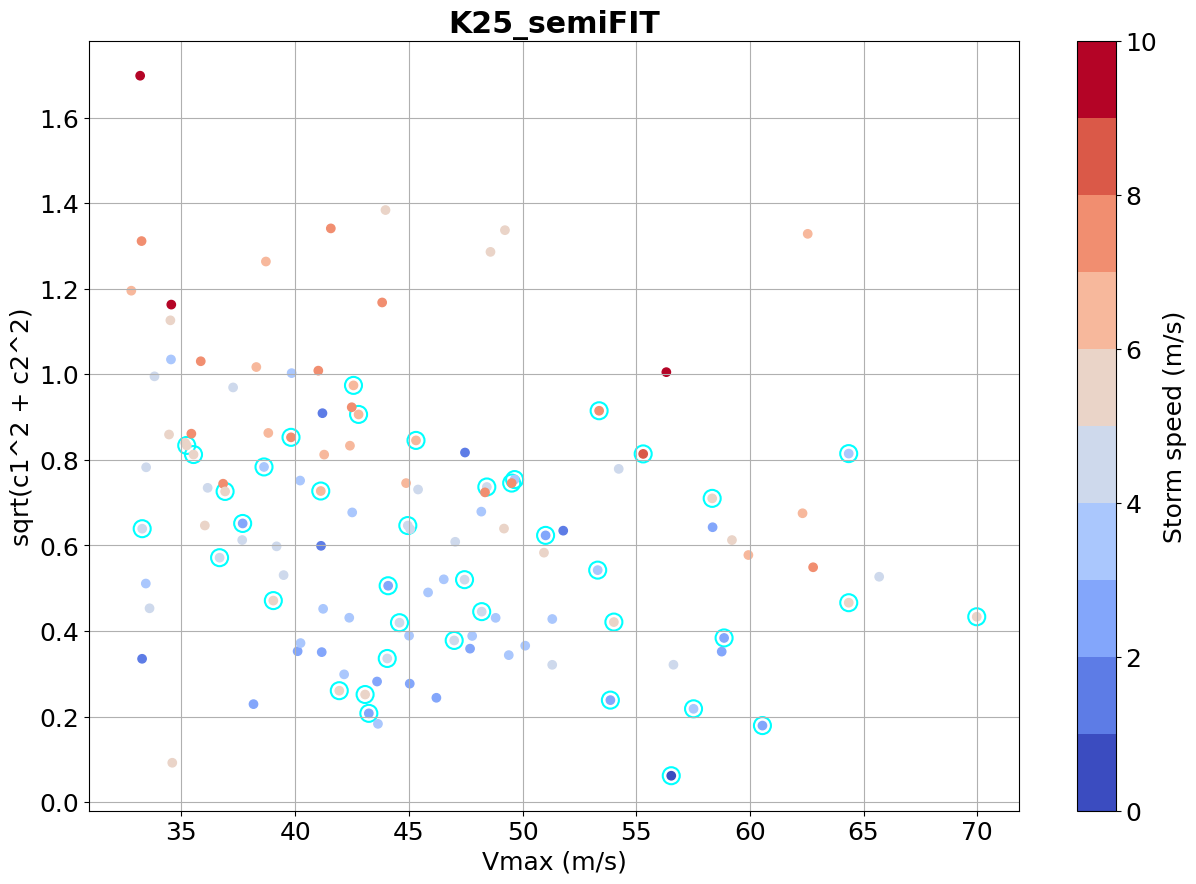

In [243]:
plt.title('K25_semiFIT', weight='bold')
plt.scatter(dsm25_sFt.where(xr.where(dsm25_sFt.non_C1 == 0, False, True)).dropna(dim='time').vmx, np.sqrt(dsm25_sFt.where(xr.where(dsm25_sFt.non_C1 == 0, False, True)).dropna(dim='time').c1_K25 ** 2 + dsm25_sFt.where(xr.where(dsm25_sFt.non_C1 == 0, False, True)).dropna(dim='time').c2_K25 ** 2), s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_sFt.dropna(dim='time').vmx, np.sqrt(dsm25_sFt.dropna(dim='time').c1_K25 ** 2 + dsm25_sFt.dropna(dim='time').c2_K25 ** 2), c=dsm25_sFt.dropna(dim='time').speed, cmap=plt.get_cmap('coolwarm', 10), vmin=0, vmax=10)
plt.xlabel('Vmax (m/s)')
plt.ylabel('sqrt(c1^2 + c2^2)')
plt.grid()
plt.colorbar(label='Storm speed (m/s)')

Text(0, 0.5, 'Estimated K (m2/s)')

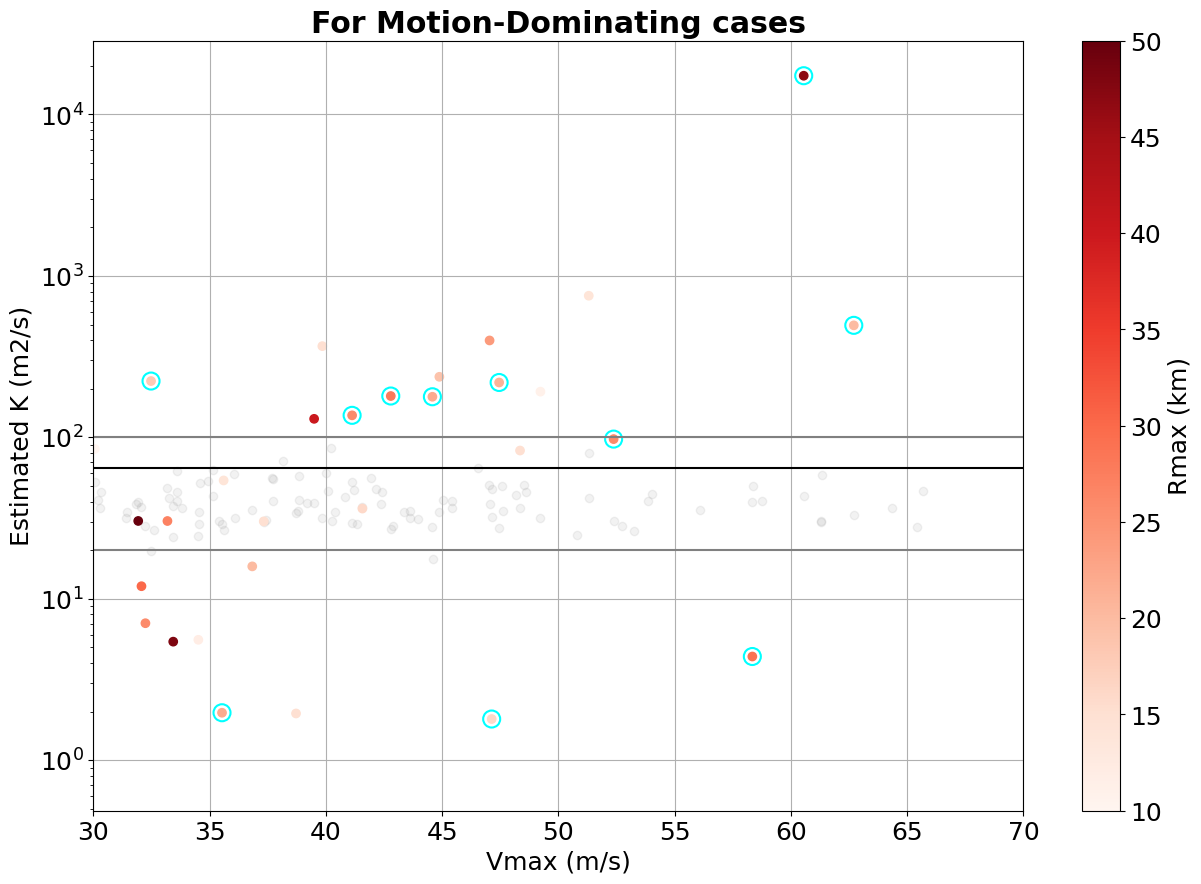

In [244]:
motionDominates = dsm25_fit.storm_speed_ibt > dsm25_fit.vws_pmd

plt.title('For Motion-Dominating cases', weight='bold')
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
plt.scatter(dsm25_fit.vmx, dsm25_fit.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm25_fit.where(xr.where(dsm25_fit.non_C1 == 0, False, True) & motionDominates).vmx, (dsm25_fit.where(xr.where(dsm25_fit.non_C1 == 0, False, True) & motionDominates).cd_mean_lp / dsm25_fit.C_sqrtK_K25) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_fit.where(motionDominates).vmx, (dsm25_fit.where(motionDominates).cd_mean_lp / dsm25_fit.where(motionDominates).C_sqrtK_K25) ** 2, c=dsm25_fit.where(motionDominates).rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
# plt.ylim(-100, 4000)
plt.yscale('log')
# plt.ylim(-10, 200)
plt.xlim(30, 70)
plt.axhline(100, c='gray')
plt.axhline(65,  c='k')
plt.axhline(20,  c='gray')
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Estimated K (m2/s)')

#### b) K01_FIT

In [245]:
dsm01_fit = xr.merge([dk01_clean,   new_dsg], join="inner", compat='override') # Fit (Clean)

Text(0, 0.5, 'Average Cd (x1e-3)')

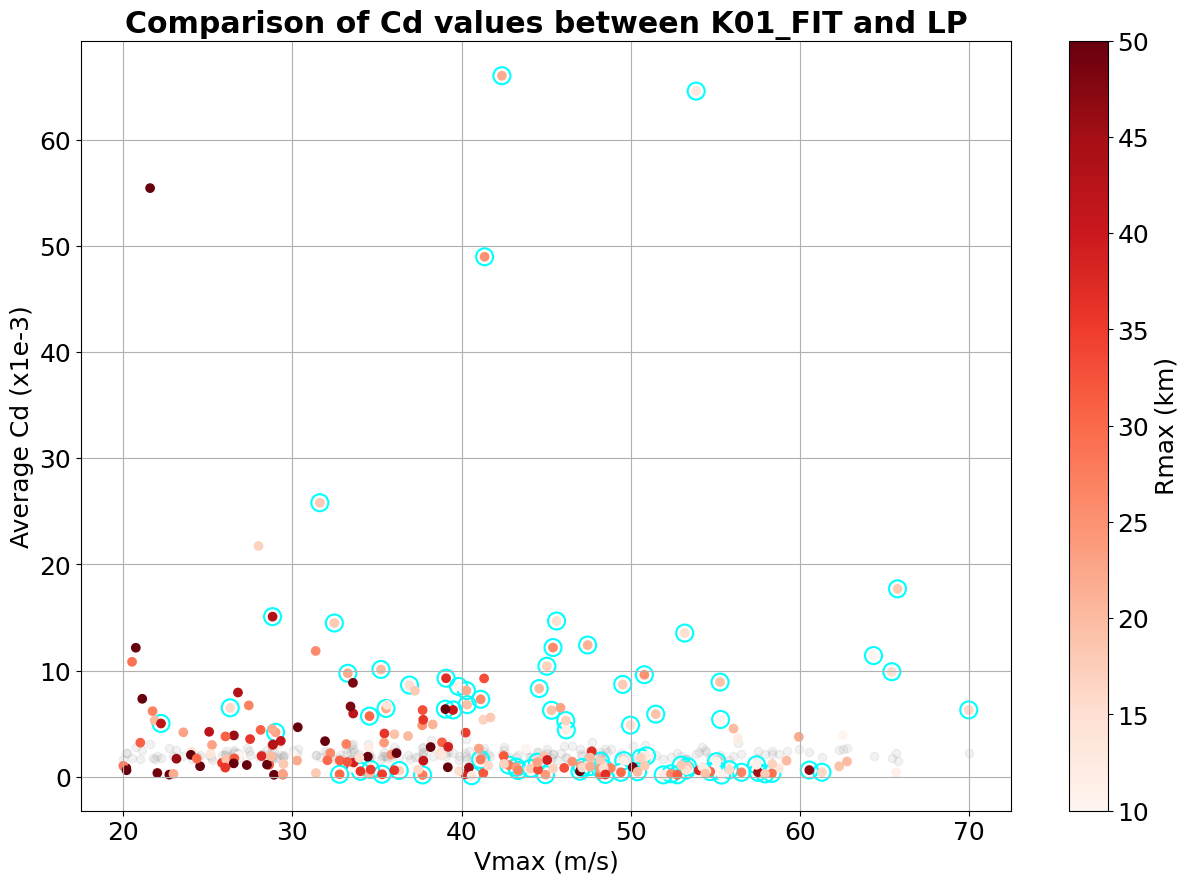

In [246]:
# In Cyan: Non-C1 points
plt.title('Comparison of Cd values between K01_FIT and LP', weight='bold')
plt.scatter(dsm01_fit.vmx, dsm01_fit.cd_mean_lp * 1e3, c='gray', alpha=0.1)
plt.scatter(dsm01_fit.where(xr.where(dsm01_fit.non_C1 == 0, False, True)).vmx, np.sqrt(dsm01_fit.where(xr.where(dsm01_fit.non_C1 == 0, False, True)).K_mean_kpp) / 1 * dsm01_fit.where(xr.where(dsm01_fit.non_C1 == 0, False, True)).C_sqrtK_K01 * 1e3, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm01_fit.vmx, np.sqrt(dsm01_fit.K_mean_kpp) / 1 * dsm01_fit.C_sqrtK_K01 * 1e3, c=dsm01_fit.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
# plt.ylim(0, 10)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

Text(0, 0.5, 'Estimated K (m2/s)')

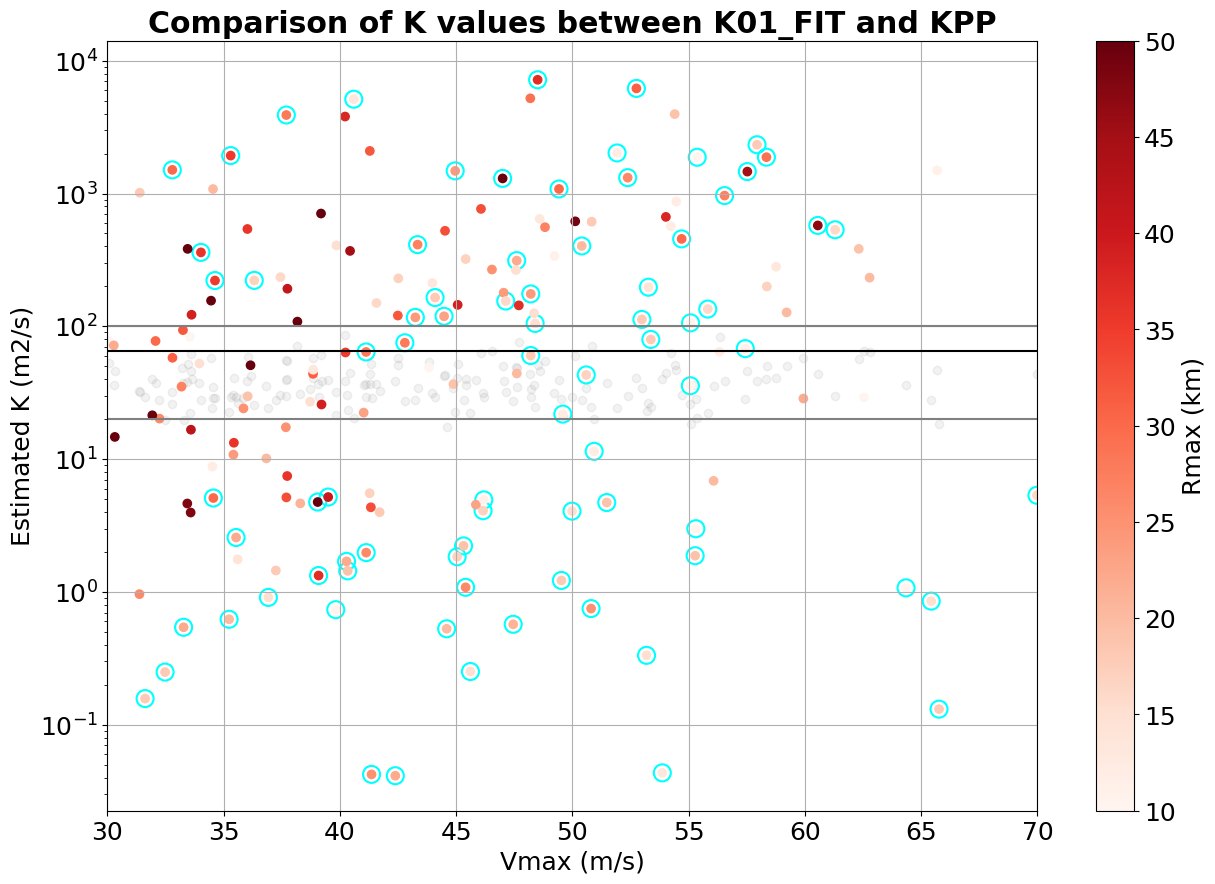

In [247]:
plt.title('Comparison of K values between K01_FIT and KPP', weight='bold')
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
plt.scatter(dsm01_fit.vmx, dsm01_fit.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm01_fit.where(xr.where(dsm01_fit.non_C1 == 0, False, True)).vmx, (dsm01_fit.where(xr.where(dsm01_fit.non_C1 == 0, False, True)).cd_mean_lp / dsm01_fit.C_sqrtK_K01) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm01_fit.vmx, (dsm01_fit.cd_mean_lp / dsm01_fit.C_sqrtK_K01) ** 2, c=dsm01_fit.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
# plt.ylim(-100, 4000)
plt.yscale('log')
# plt.ylim(-10, 200)
plt.xlim(30, 70)
plt.axhline(100, c='gray')
plt.axhline(65,  c='k')
plt.axhline(20,  c='gray')
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Estimated K (m2/s)')

Text(0, 0.5, 'Average Cd from K01_FIT (x1e-3)')

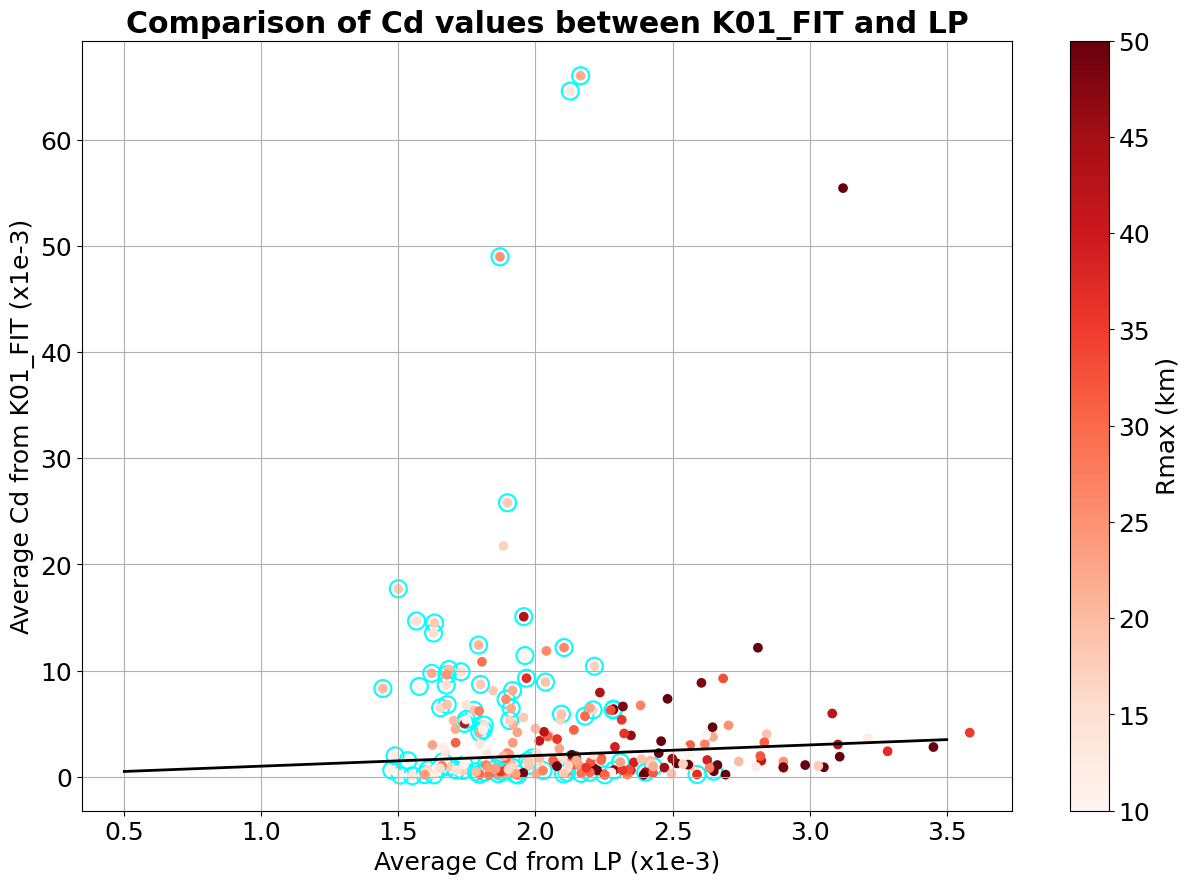

In [248]:
# In Cyan: Non-C1 points
plt.title('Comparison of Cd values between K01_FIT and LP', weight='bold')

plt.scatter(dsm01_fit.where(xr.where(dsm01_fit.non_C1 == 0, False, True)).cd_mean_lp * 1e3, np.sqrt(dsm01_fit.where(xr.where(dsm01_fit.non_C1 == 0, False, True)).K_mean_kpp) / 1 * dsm01_fit.C_sqrtK_K01 * 1e3,  s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm01_fit.cd_mean_lp * 1e3, np.sqrt(dsm01_fit.K_mean_kpp) / 1 * dsm01_fit.C_sqrtK_K01 * 1e3, c=dsm01_fit.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.plot([0.5, 3.5], [0.5, 3.5], c='k', linewidth=2)
# plt.ylim(0, 4)
plt.grid()
plt.xlabel('Average Cd from LP (x1e-3)')
plt.ylabel('Average Cd from K01_FIT (x1e-3)')

Text(0, 0.5, 'Estimated K from K01_FIT (m2/s)')

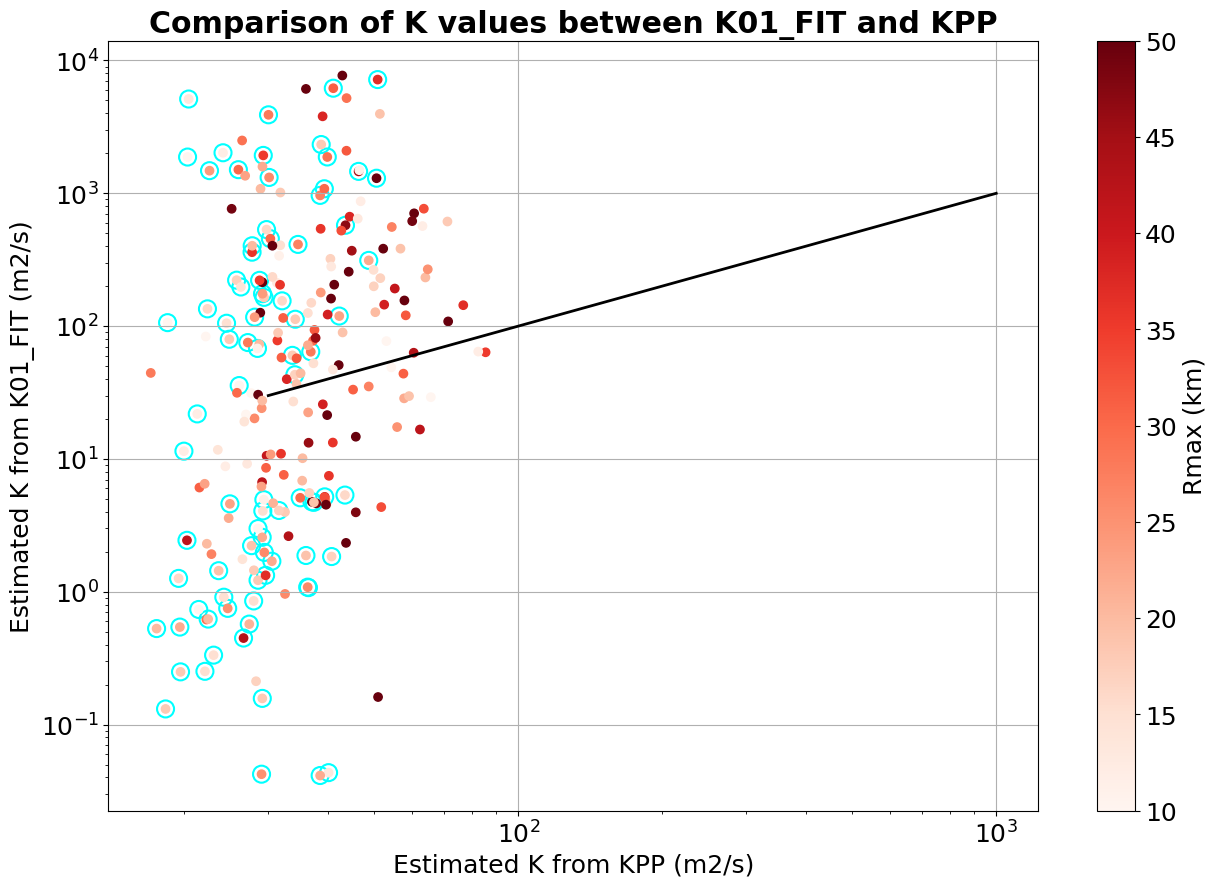

In [249]:
plt.title('Comparison of K values between K01_FIT and KPP', weight='bold')
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
# plt.scatter(dsm01_fit.vmx, dsm01_fit.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm01_fit.where(xr.where(dsm01_fit.non_C1 == 0, False, True)).K_mean_kpp, (dsm01_fit.where(xr.where(dsm01_fit.non_C1 == 0, False, True)).cd_mean_lp / dsm01_fit.C_sqrtK_K01) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm01_fit.K_mean_kpp, (dsm01_fit.cd_mean_lp / dsm01_fit.C_sqrtK_K01) ** 2, c=dsm01_fit.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.xscale('log');plt.yscale('log')
plt.plot([30, 1e3], [30, 1e3], c='k', linewidth=2)
# plt.ylim(1, 500)
plt.grid()
plt.xlabel('Estimated K from KPP (m2/s)')
plt.ylabel('Estimated K from K01_FIT (m2/s)')

Text(0, 0.5, 'Estimated K from K01_FIT (m2/s)')

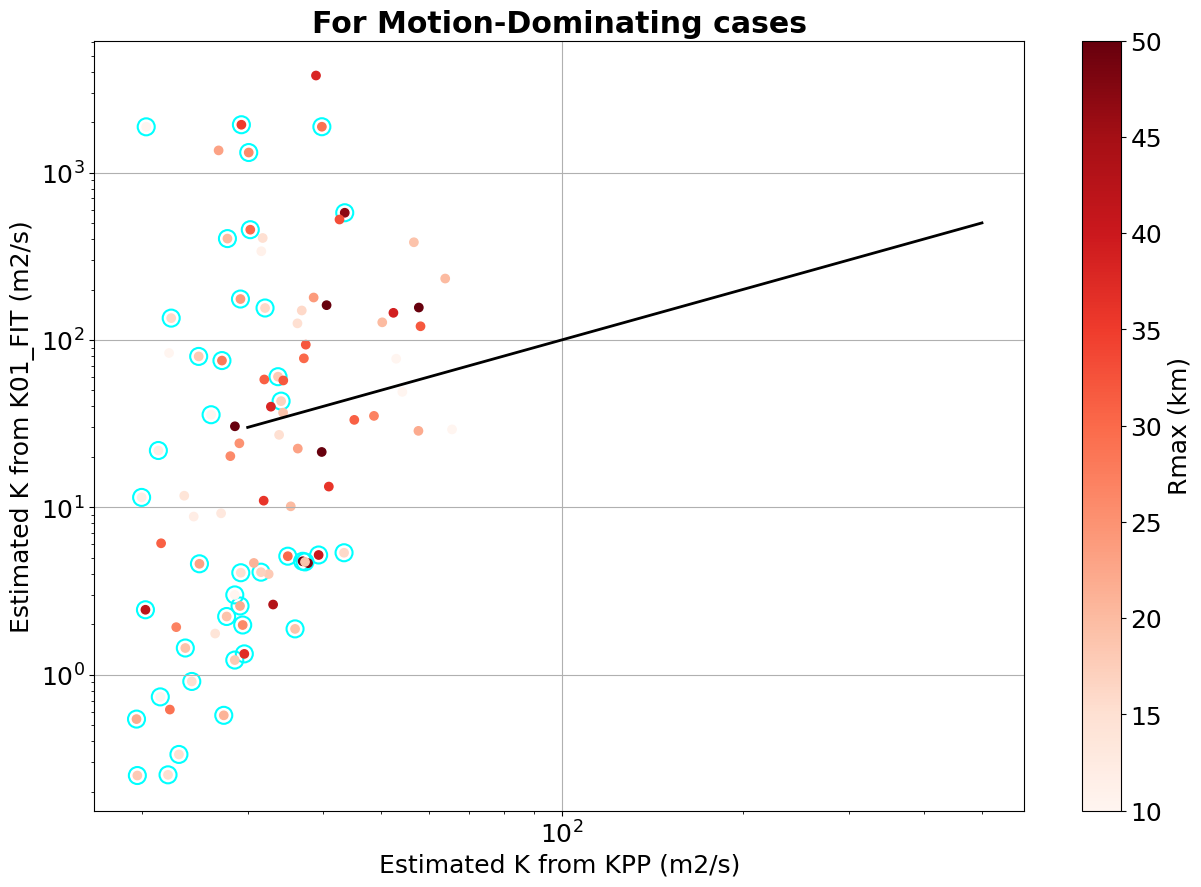

In [250]:
motionDominates = dsm01_fit.storm_speed_ibt > dsm01_fit.vws_pmd

plt.title('For Motion-Dominating cases', weight='bold')
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
# plt.scatter(dsm01_fit.vmx, dsm01_fit.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm01_fit.where(xr.where(dsm01_fit.non_C1 == 0, False, True) & motionDominates).K_mean_kpp, (dsm01_fit.where(xr.where(dsm01_fit.non_C1 == 0, False, True) & motionDominates).cd_mean_lp / dsm01_fit.C_sqrtK_K01) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm01_fit.where(motionDominates).K_mean_kpp, (dsm01_fit.where(motionDominates).cd_mean_lp / dsm01_fit.where(motionDominates).C_sqrtK_K01) ** 2, c=dsm01_fit.where(motionDominates).rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.xscale('log');plt.yscale('log')
plt.plot([30, 5e2], [30, 5e2], c='k', linewidth=2)
# plt.ylim(1, 500)
plt.grid()
plt.xlabel('Estimated K from KPP (m2/s)')
plt.ylabel('Estimated K from K01_FIT (m2/s)')

#### c) Consistency between K01_FIT and K25_FIT

In [251]:
dsmg_fit = xr.merge([dsm01_fit, dsm25_fit], join="inner", compat='override')
isC1     = xr.where(dsm01_fit.non_C1 == 0, False, True) & xr.where(dsm25_fit.non_C1 == 0, False, True)

Text(0, 0.5, 'Average Cd from K25_FIT (x1e-3)')

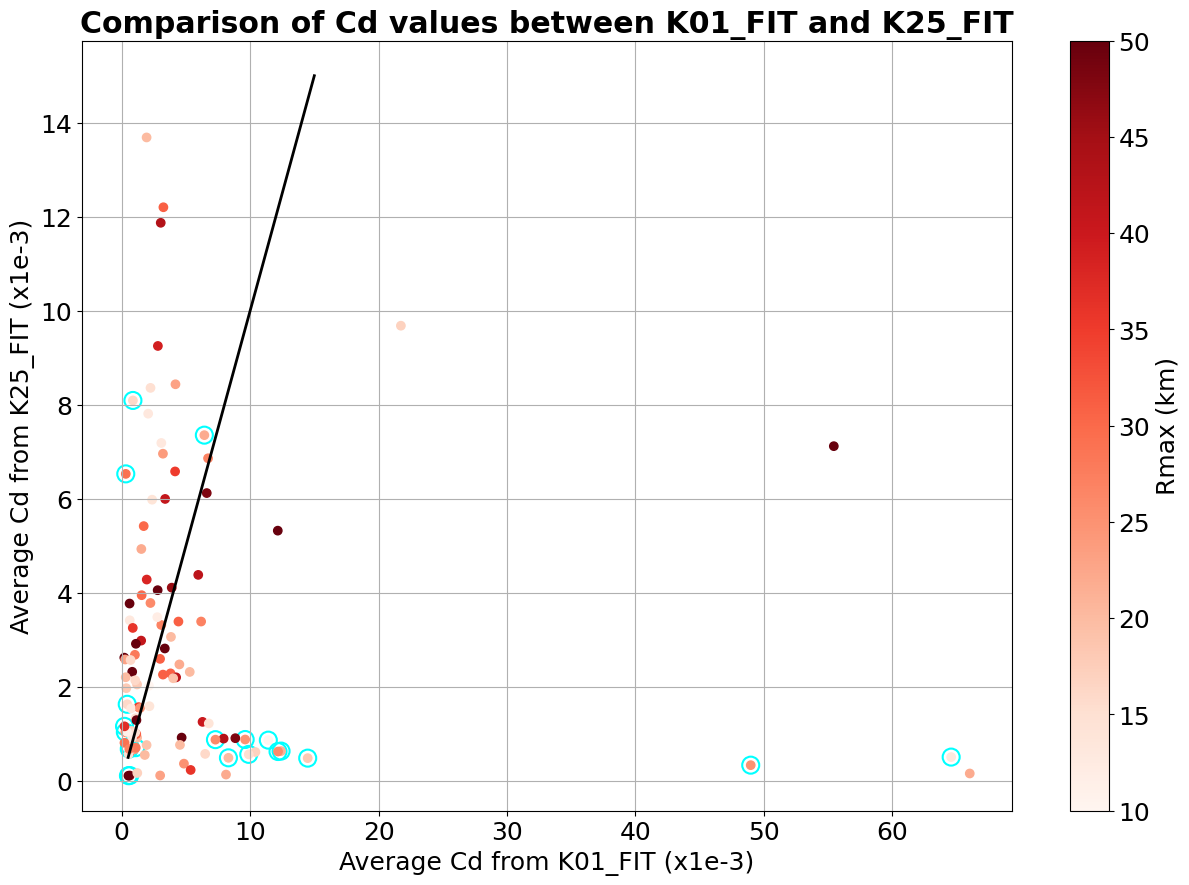

In [252]:
plt.title('Comparison of Cd values between K01_FIT and K25_FIT', weight='bold')
plt.scatter(np.sqrt(dsmg_fit.where(isC1).K_mean_kpp) / 1 * dsmg_fit.where(isC1).C_sqrtK_K01 * 1e3, np.sqrt(dsmg_fit.where(isC1).K_mean_kpp) / 1 * dsmg_fit.where(isC1).C_sqrtK_K25 * 1e3, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(np.sqrt(dsmg_fit.K_mean_kpp) / 1 * dsmg_fit.C_sqrtK_K01 * 1e3, np.sqrt(dsmg_fit.K_mean_kpp) / 1 * dsmg_fit.C_sqrtK_K25 * 1e3, c=dsmg_fit.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.plot([0.5, 15], [0.5, 15], c='k', linewidth=2)
# plt.xlim(0, 20);plt.ylim(0, 20)
plt.grid()
plt.xlabel('Average Cd from K01_FIT (x1e-3)')
plt.ylabel('Average Cd from K25_FIT (x1e-3)')

Text(0, 0.5, 'Average K from K25_FIT (x1e-3)')

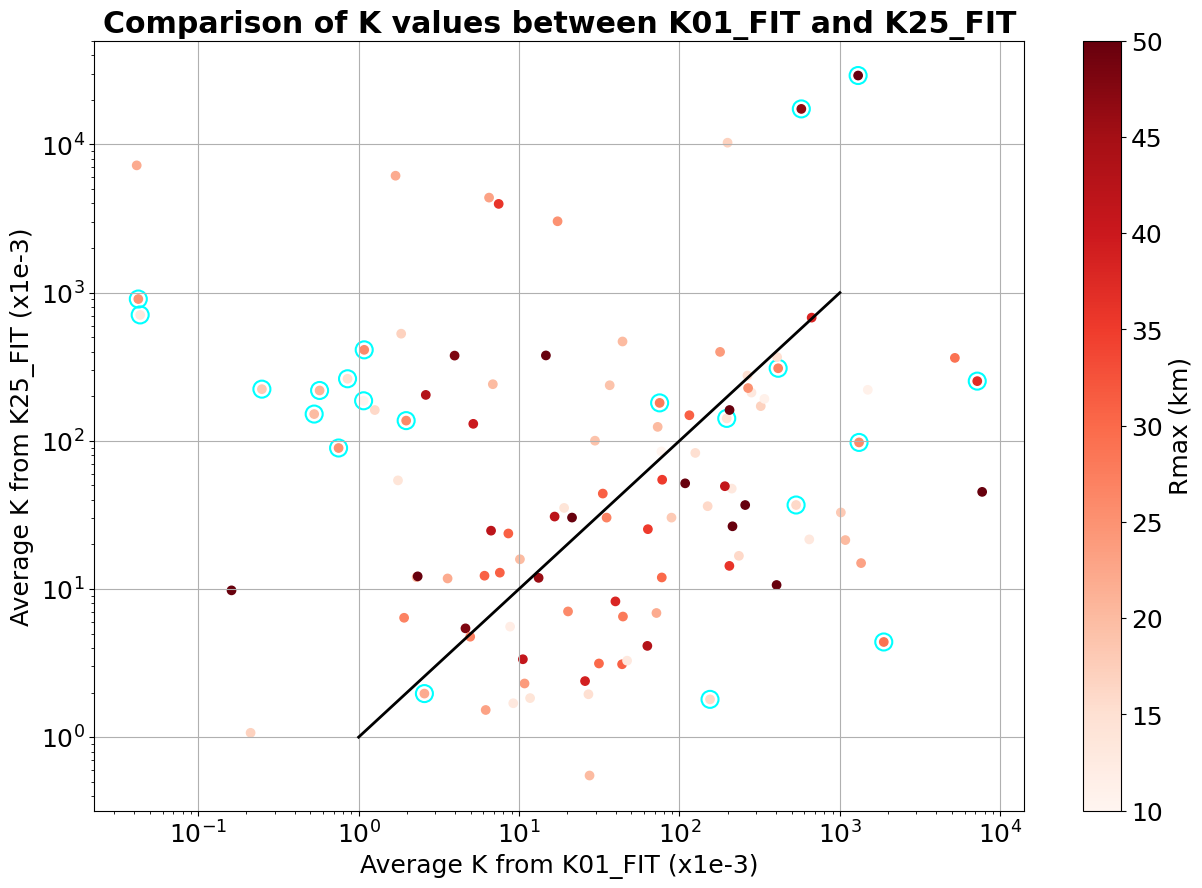

In [253]:
plt.title('Comparison of K values between K01_FIT and K25_FIT', weight='bold')
plt.scatter((dsmg_fit.where(isC1).cd_mean_lp / dsmg_fit.where(isC1).C_sqrtK_K01) ** 2, (dsmg_fit.where(isC1).cd_mean_lp / dsmg_fit.where(isC1).C_sqrtK_K25) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter((dsmg_fit.cd_mean_lp / dsmg_fit.C_sqrtK_K01) ** 2, (dsmg_fit.cd_mean_lp / dsmg_fit.C_sqrtK_K25) ** 2, c=dsmg_fit.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.xscale('log');plt.yscale('log')
plt.plot([1, 1e3], [1, 1e3], c='k', linewidth=2)
plt.grid()
plt.xlabel('Average K from K01_FIT (x1e-3)')
plt.ylabel('Average K from K25_FIT (x1e-3)')

Text(0, 0.5, 'Average C / sqrt(K) from K25_FIT')

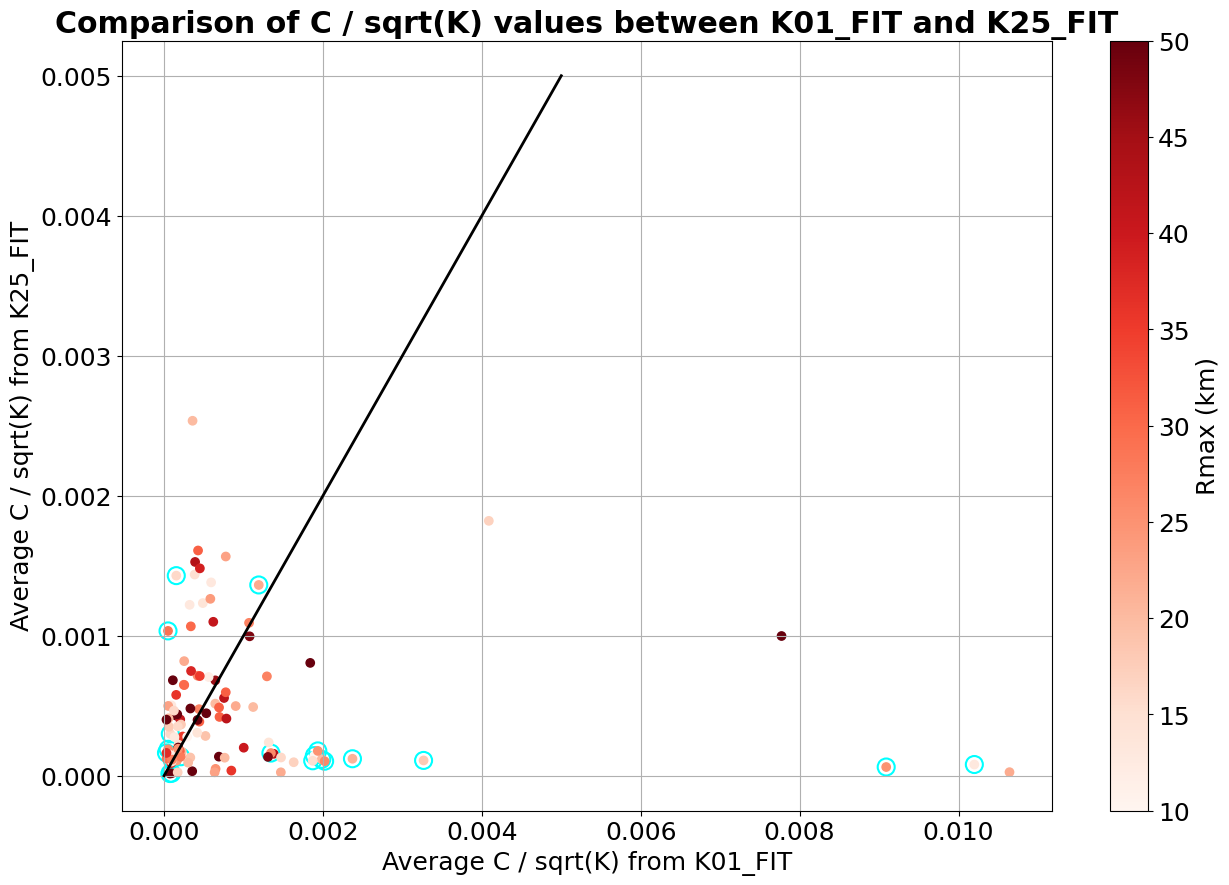

In [254]:
plt.title('Comparison of C / sqrt(K) values between K01_FIT and K25_FIT', weight='bold')
plt.scatter(dsmg_fit.where(isC1).C_sqrtK_K01, dsmg_fit.where(isC1).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsmg_fit.C_sqrtK_K01, dsmg_fit.C_sqrtK_K25, c=dsmg_fit.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.plot([0., 0.005], [0., 0.005], c='k', linewidth=2)
# plt.xlim(0, 20);plt.ylim(0, 20)
plt.grid()
plt.xlabel('Average C / sqrt(K) from K01_FIT')
plt.ylabel('Average C / sqrt(K) from K25_FIT')

Text(0, 0.5, 'Average C / sqrt(K) from K25_FIT')

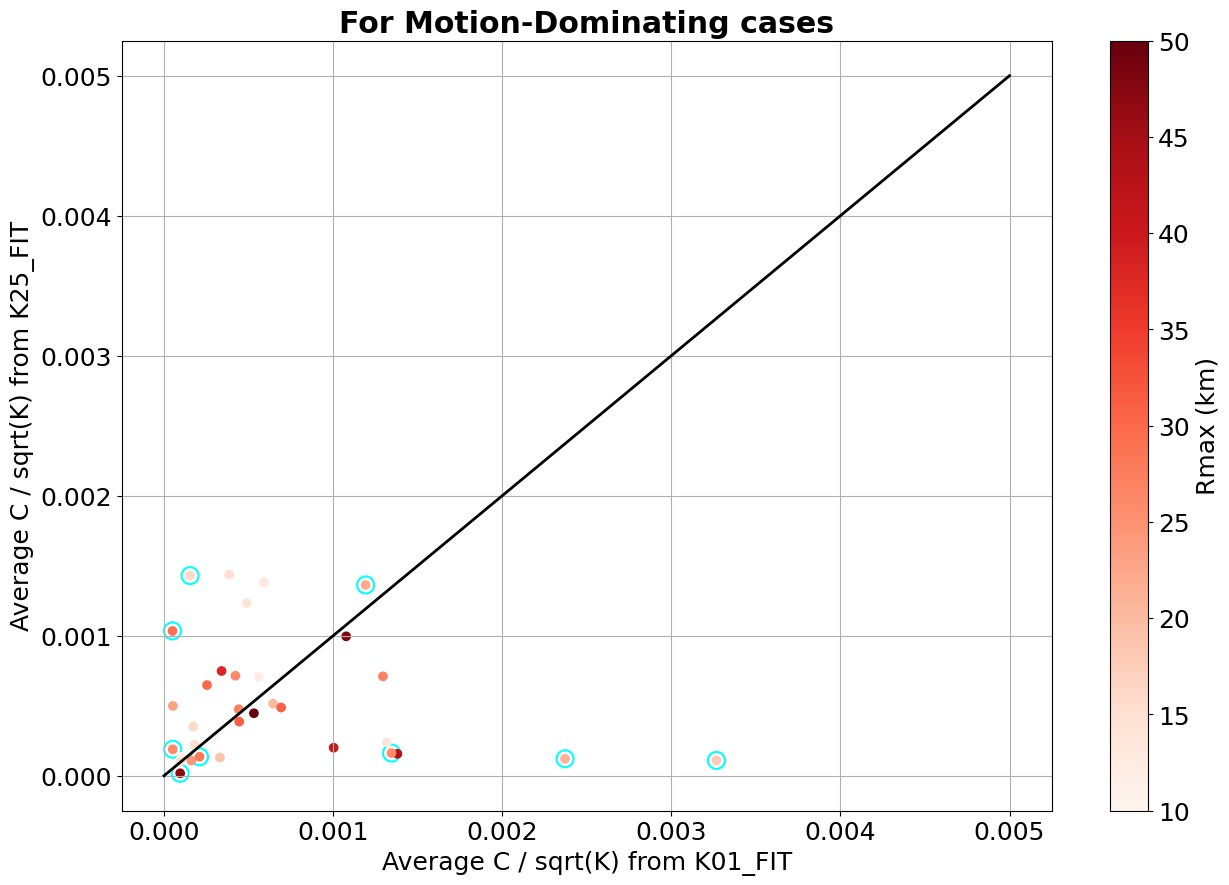

In [255]:
motionDOminates = dsmg_fit.storm_speed_ibt > dsmg_fit.vws_pmd

plt.title('For Motion-Dominating cases', weight='bold')
plt.scatter(dsmg_fit.where(motionDOminates & isC1).C_sqrtK_K01, dsmg_fit.where(motionDOminates & isC1).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsmg_fit.where(motionDOminates).C_sqrtK_K01, dsmg_fit.where(motionDOminates).C_sqrtK_K25, c=dsmg_fit.where(motionDOminates).rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.plot([0., 0.005], [0., 0.005], c='k', linewidth=2)
# plt.xlim(0, 20);plt.ylim(0, 20)
plt.grid()
plt.xlabel('Average C / sqrt(K) from K01_FIT')
plt.ylabel('Average C / sqrt(K) from K25_FIT')

#### d) K25_wIA

In [256]:
dsm25_wIA = xr.merge([dk25i_clean,   new_dsg], join="inner", compat='override') # Fit (Clean)

Text(0, 0.5, 'Average Cd (x1e-3)')

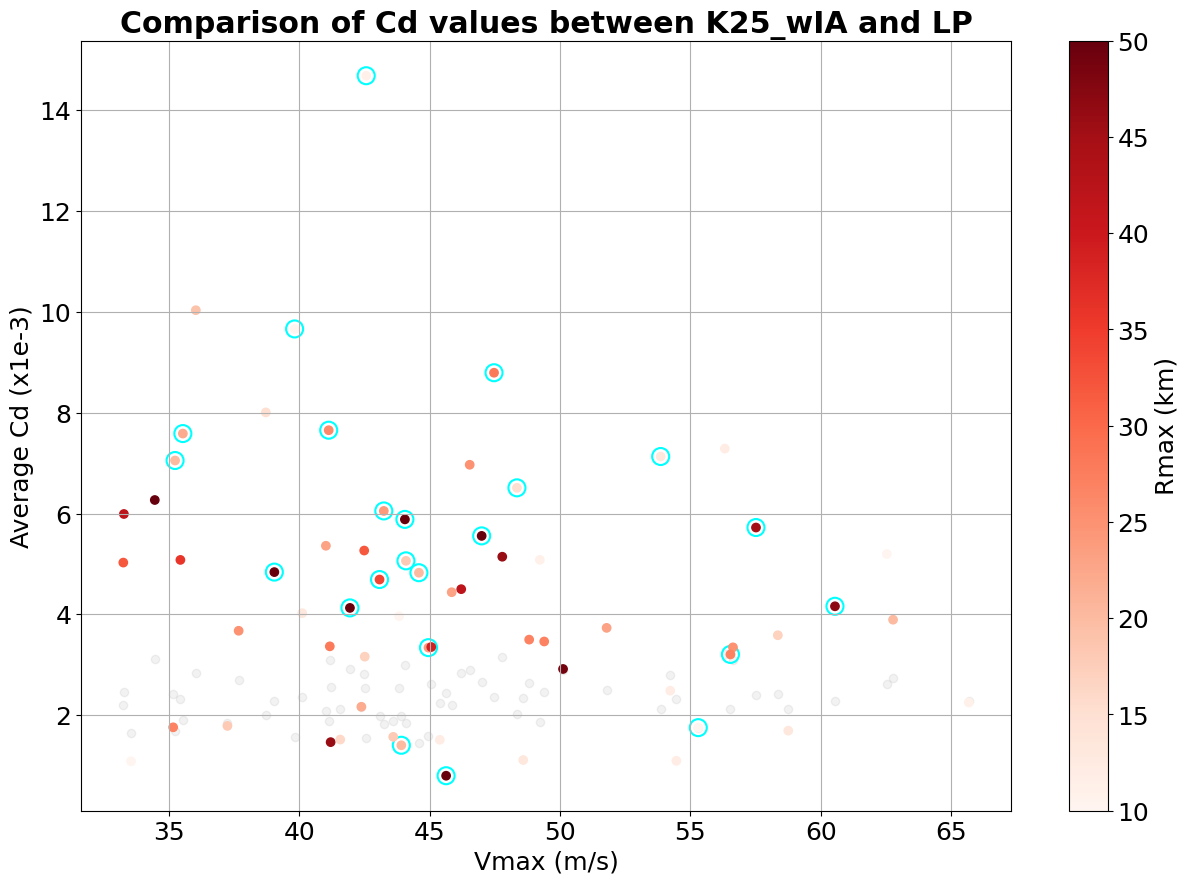

In [257]:
# In Cyan: Non-C1 points
plt.title('Comparison of Cd values between K25_wIA and LP', weight='bold')
plt.scatter(dsm25_wIA.vmx, dsm25_wIA.cd_mean_lp * 1e3, c='gray', alpha=0.1)
plt.scatter(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).vmx, np.sqrt(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).K_mean_kpp) / 1 * dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).C_sqrtK_K25 * 1e3, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_wIA.vmx, np.sqrt(dsm25_wIA.K_mean_kpp) / 1 * dsm25_wIA.C_sqrtK_K25 * 1e3, c=dsm25_wIA.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
# plt.ylim(0, 10)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

Text(0, 0.5, 'Estimated K (m2/s)')

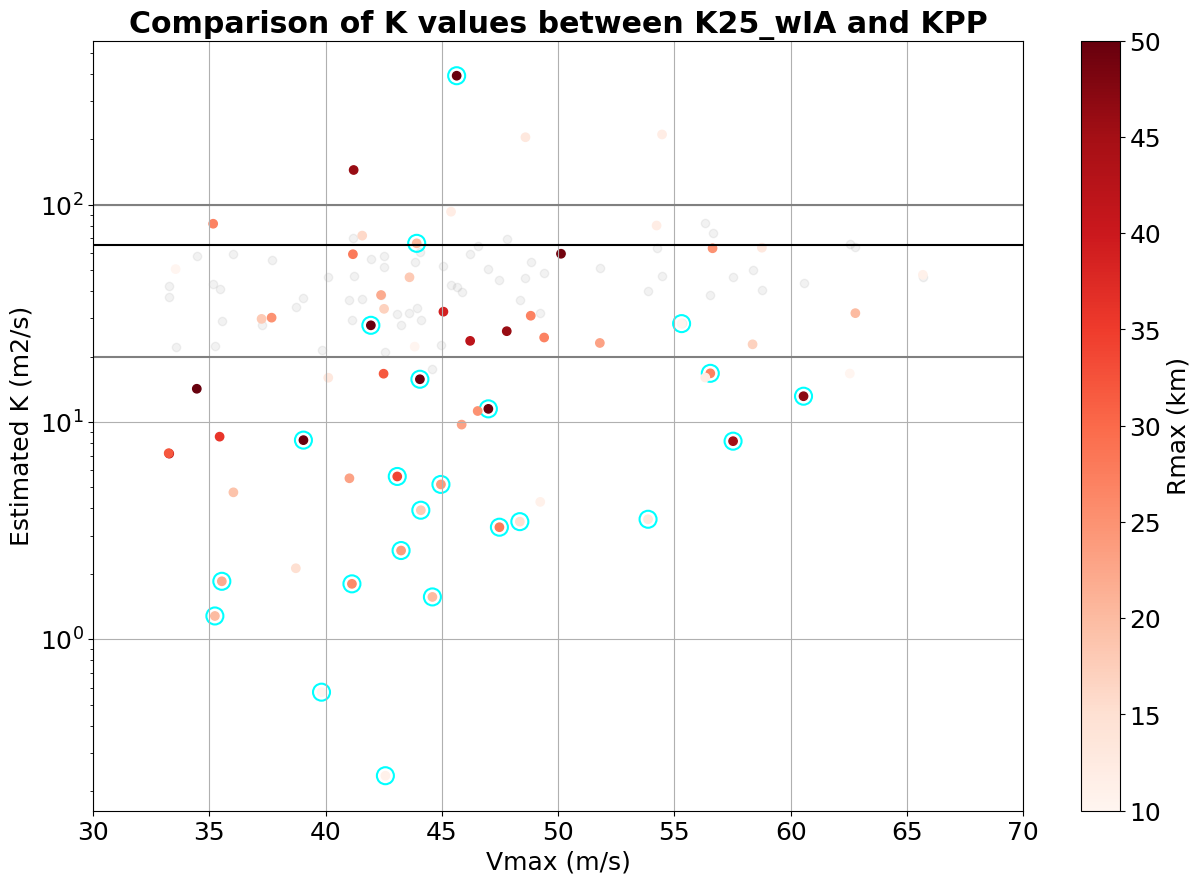

In [258]:
plt.title('Comparison of K values between K25_wIA and KPP', weight='bold')
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
plt.scatter(dsm25_wIA.vmx, dsm25_wIA.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).vmx, (dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).cd_mean_lp / dsm25_wIA.C_sqrtK_K25) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_wIA.vmx, (dsm25_wIA.cd_mean_lp / dsm25_wIA.C_sqrtK_K25) ** 2, c=dsm25_wIA.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
# plt.ylim(-100, 4000)
plt.yscale('log')
# plt.ylim(-10, 200)
plt.xlim(30, 70)
plt.axhline(100, c='gray')
plt.axhline(65,  c='k')
plt.axhline(20,  c='gray')
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Estimated K (m2/s)')

Text(0, 0.5, 'Average Cd from K25_FIT (x1e-3)')

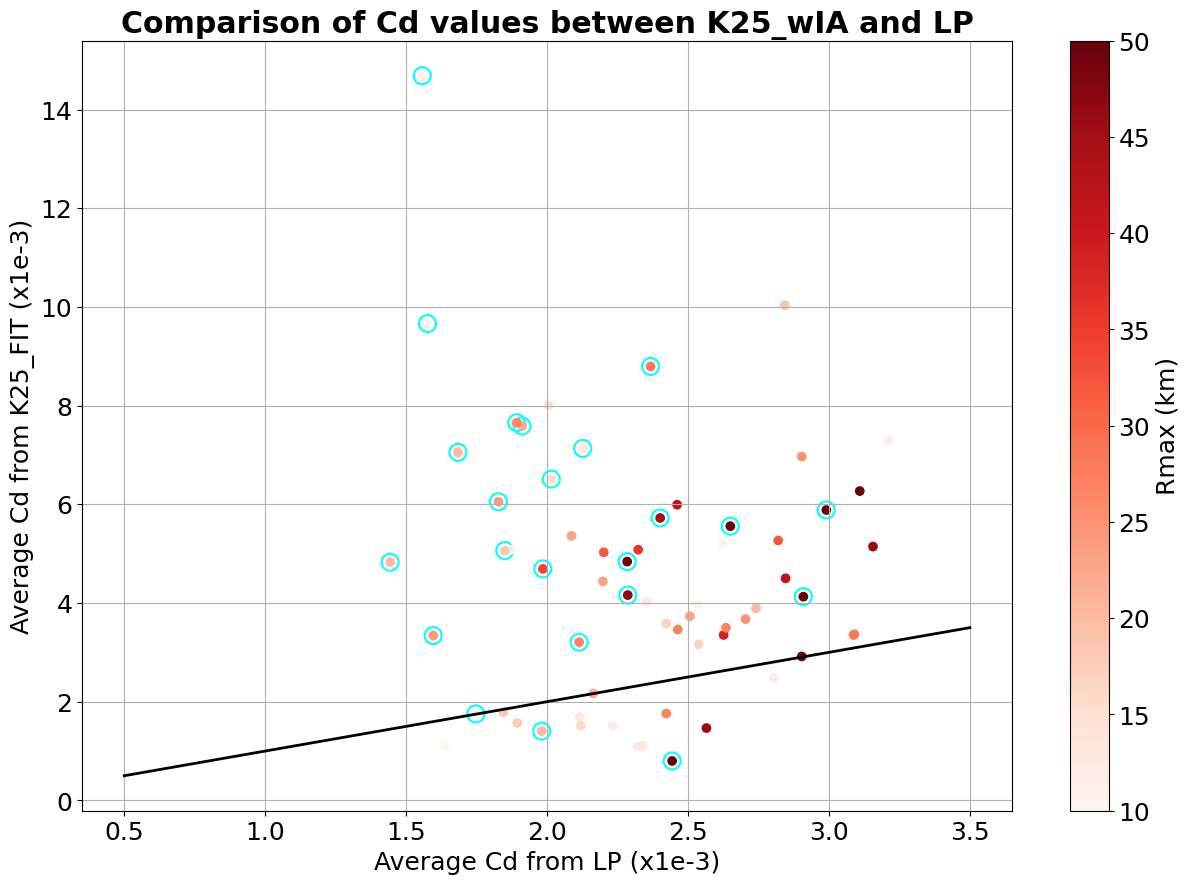

In [259]:
# In Cyan: Non-C1 points
plt.title('Comparison of Cd values between K25_wIA and LP', weight='bold')

plt.scatter(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).cd_mean_lp * 1e3, np.sqrt(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).K_mean_kpp) / 1 * dsm25_wIA.C_sqrtK_K25 * 1e3,  s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_wIA.cd_mean_lp * 1e3, np.sqrt(dsm25_wIA.K_mean_kpp) / 1 * dsm25_wIA.C_sqrtK_K25 * 1e3, c=dsm25_wIA.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.plot([0.5, 3.5], [0.5, 3.5], c='k', linewidth=2)
# plt.ylim(0, 4)
plt.grid()
plt.xlabel('Average Cd from LP (x1e-3)')
plt.ylabel('Average Cd from K25_FIT (x1e-3)')

Text(0, 0.5, 'Estimated K from K25_FIT (m2/s)')

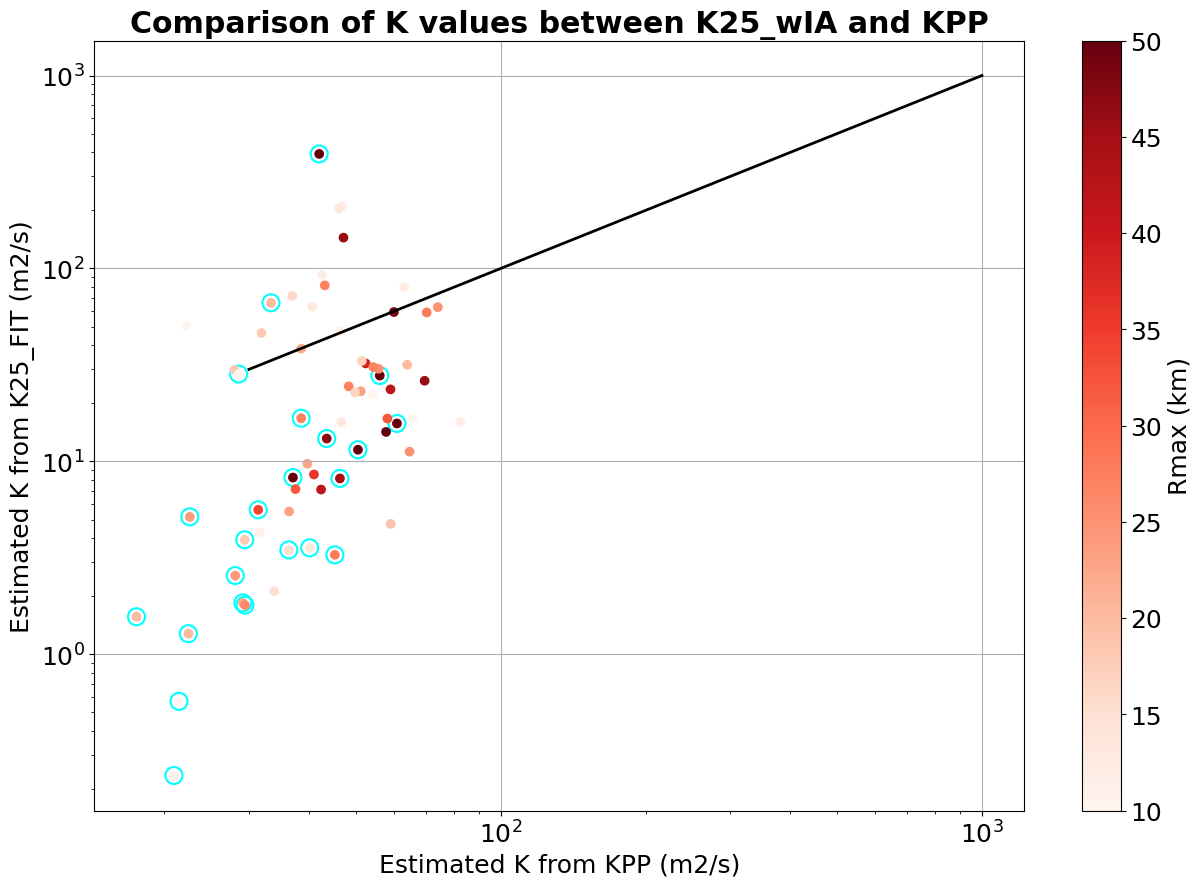

In [260]:
plt.title('Comparison of K values between K25_wIA and KPP', weight='bold')
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
# plt.scatter(dsm25_wIA.vmx, dsm25_wIA.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).K_mean_kpp, (dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).cd_mean_lp / dsm25_wIA.C_sqrtK_K25) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_wIA.K_mean_kpp, (dsm25_wIA.cd_mean_lp / dsm25_wIA.C_sqrtK_K25) ** 2, c=dsm25_wIA.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.xscale('log');plt.yscale('log')
plt.plot([30, 1e3], [30, 1e3], c='k', linewidth=2)
# plt.ylim(1, 500)
plt.grid()
plt.xlabel('Estimated K from KPP (m2/s)')
plt.ylabel('Estimated K from K25_FIT (m2/s)')

Text(0, 0.5, 'Estimated K from K25_FIT (m2/s)')

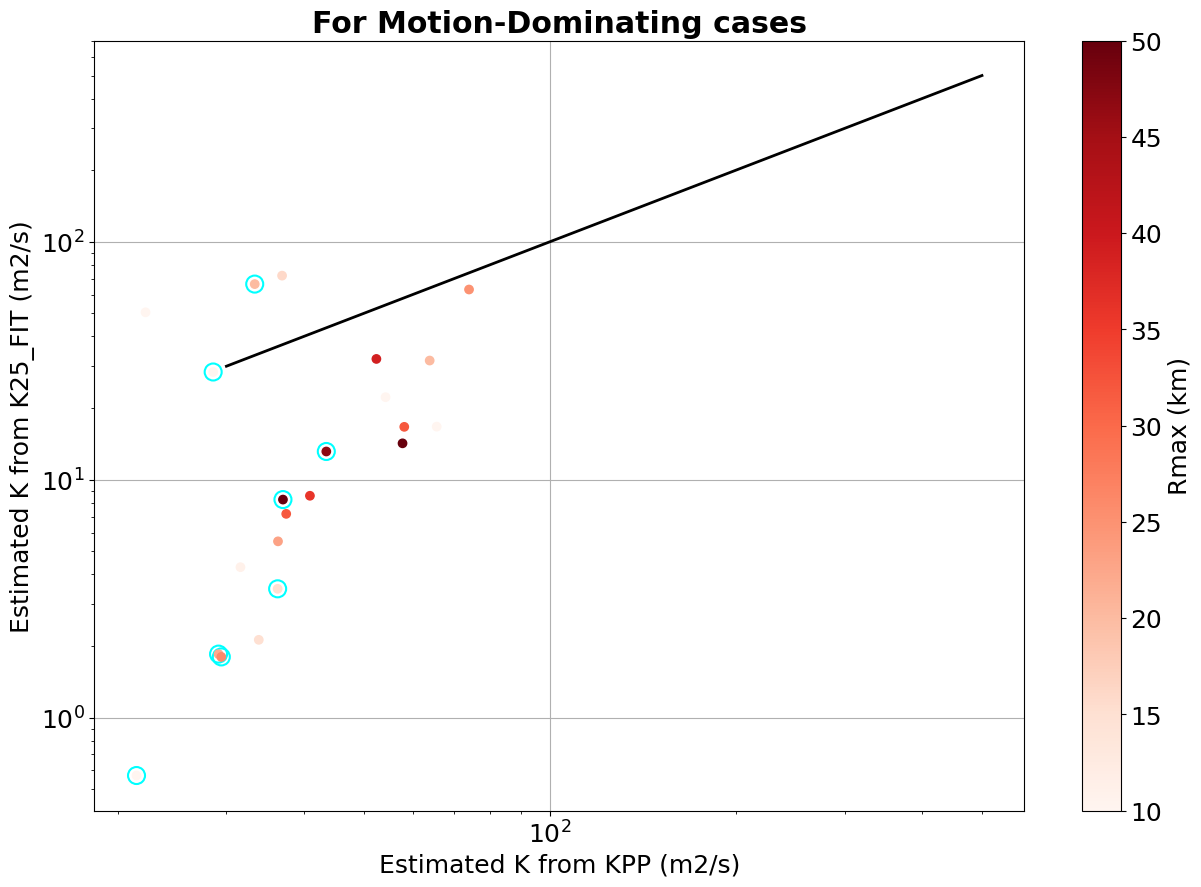

In [261]:
motionDominates = dsm25_wIA.storm_speed_ibt > dsm25_wIA.vws_pmd

plt.title('For Motion-Dominating cases', weight='bold')
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
# plt.scatter(dsm25_wIA.vmx, dsm25_wIA.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True) & motionDominates).K_mean_kpp, (dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True) & motionDominates).cd_mean_lp / dsm25_wIA.C_sqrtK_K25) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm25_wIA.where(motionDominates).K_mean_kpp, (dsm25_wIA.where(motionDominates).cd_mean_lp / dsm25_wIA.where(motionDominates).C_sqrtK_K25) ** 2, c=dsm25_wIA.where(motionDominates).rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.xscale('log');plt.yscale('log')
plt.plot([30, 5e2], [30, 5e2], c='k', linewidth=2)
# plt.ylim(1, 500)
plt.grid()
plt.xlabel('Estimated K from KPP (m2/s)')
plt.ylabel('Estimated K from K25_FIT (m2/s)')

In [262]:
# ### TEST

# plt.title('K values as a function of Vmax and t_LMI (K25)', weight='bold')
# # plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
# # plt.scatter(dsm25_wIA.vmx, dsm25_wIA.K_mean_kpp, c='gray', alpha=0.1)
# plt.scatter(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).vmx, (dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).cd_mean_lp / dsm25_wIA.C_sqrtK_K25) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
# plt.scatter(dsm25_wIA.vmx, (dsm25_wIA.cd_mean_lp / dsm25_wIA.C_sqrtK_K25) ** 2, c=dsm25_wIA.t_since_lmi_ibt / 3600, vmin=-100, vmax=100, cmap=plt.get_cmap('coolwarm', 5))
# plt.colorbar(label='t since LMI (hours)')
# # plt.ylim(-100, 4000)
# plt.yscale('log')
# # plt.ylim(-10, 200)
# plt.xlim(30, 70)
# plt.axhline(100, c='gray')
# plt.axhline(65,  c='k')
# plt.axhline(20,  c='gray')
# plt.grid()
# plt.xlabel('Vmax (m/s)')
# plt.ylabel('Estimated K (m2/s)')

# plt.show()

# plt.title('For Motion-Dominating cases (K25)', weight='bold')
# # plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
# # plt.scatter(dsm25_wIA.vmx, dsm25_wIA.K_mean_kpp, c='gray', alpha=0.1)
# plt.scatter(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True) & motionDominates).vmx, (dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True) & motionDominates).cd_mean_lp / dsm25_wIA.C_sqrtK_K25) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
# plt.scatter(dsm25_wIA.vmx, (dsm25_wIA.where(motionDominates).cd_mean_lp / dsm25_wIA.where(motionDominates).C_sqrtK_K25) ** 2, c=dsm25_wIA.where(motionDominates).t_since_lmi_ibt / 3600, vmin=-100, vmax=100, cmap=plt.get_cmap('coolwarm', 5))
# plt.colorbar(label='t since LMI (hours)')
# # plt.ylim(-100, 4000)
# plt.yscale('log')
# # plt.ylim(-10, 200)
# plt.xlim(30, 70)
# plt.axhline(100, c='gray')
# plt.axhline(65,  c='k')
# plt.axhline(20,  c='gray')
# plt.grid()
# plt.xlabel('Vmax (m/s)')
# plt.ylabel('Estimated K (m2/s)')

In [263]:
# ### TEST

# dsm25_wIA['wght_cont']  = dsm25_wIA.storm_speed_ibt * np.cos(np.deg2rad(dsm25_wIA.storm_dir_ibt)) + dsm25_wIA.vws_pmd * np.cos(np.deg2rad(dsm25_wIA.wsd_pmd))
# angles                  = (np.rad2deg(np.arctan((dsm25_wIA.c1_K25 / dsm25_wIA.c2_K25))) % 360).copy(deep=True)
# angles_bis              = xr.where(angles >= 180, angles, angles + 360)
# dsm25_wIA['angles_bis'] = angles_bis

# plt.title('K25_wIA', weight='bold')
# # c1 / c2 as a function of relative contribution from shear and motion vectors
# # NB: les outliers en haut semblent normaux
# # NB: l'outlier tout à gauche à un Vmax très faible, proche de 20 m/s
# plt.scatter(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).dropna(dim='time').wght_cont, dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).dropna(dim='time').angles_bis, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
# plt.scatter(dsm25_wIA.dropna(dim='time').wght_cont, dsm25_wIA.dropna(dim='time').angles_bis, c=dsm25_wIA.dropna(dim='time').vmx, vmin=20, vmax=60)
# plt.colorbar(label='Vmax (m/s)')
# plt.xlabel('Weighted contribution of motion and shear vectors to asymmetry (m/s)')
# plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
# plt.grid()
# plt.show()


# plt.title('K25_wIA', weight='bold')

# keep       = (dsm25_wIA.lat > 0) & (~np.isnan(dsm25_wIA.wsd_pmd)) & (~np.isnan(dsm25_wIA.storm_dir_ibt))
# x_variable = xr.where((dsm25_wIA.wsd_pmd - dsm25_wIA.storm_dir_ibt) % 360 < 180, (dsm25_wIA.wsd_pmd - dsm25_wIA.storm_dir_ibt) % 360, (dsm25_wIA.wsd_pmd - dsm25_wIA.storm_dir_ibt) % 360 - 360)

# plt.scatter(x_variable.where(xr.where(dsm25_wIA.non_C1 == 0, False, True))[keep].dropna(dim='time'), dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).angles_bis[keep].dropna(dim='time'), s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
# plt.scatter(x_variable[keep].dropna(dim='time'), dsm25_wIA.angles_bis[keep].dropna(dim='time'), c=dsm25_wIA.vmx[keep].dropna(dim='time'), vmin=20, vmax=60)
# plt.colorbar(label='Vmax (m/s)')
# plt.xlabel('Shear direction relative to motion (°)')
# plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
# plt.grid()
# plt.show()


# plt.title('K25_wIA', weight='bold')
# plt.scatter(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).dropna(dim='time').vmx, np.sqrt(dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).dropna(dim='time').c1_K25 ** 2 + dsm25_wIA.where(xr.where(dsm25_wIA.non_C1 == 0, False, True)).dropna(dim='time').c2_K25 ** 2), s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
# plt.scatter(dsm25_wIA.dropna(dim='time').vmx, np.sqrt(dsm25_wIA.dropna(dim='time').c1_K25 ** 2 + dsm25_wIA.dropna(dim='time').c2_K25 ** 2), c=dsm25_wIA.dropna(dim='time').speed, cmap=plt.get_cmap('coolwarm', 10), vmin=0, vmax=10)
# plt.xlabel('Vmax (m/s)')
# plt.ylabel('sqrt(c1^2 + c2^2)')
# plt.grid()
# plt.colorbar(label='Storm speed (m/s)')

#### e) K01_wIA

In [264]:
dsm01_wIA = xr.merge([dk01i_clean,   new_dsg], join="inner", compat='override') # Fit (Clean)

Text(0, 0.5, 'Average Cd (x1e-3)')

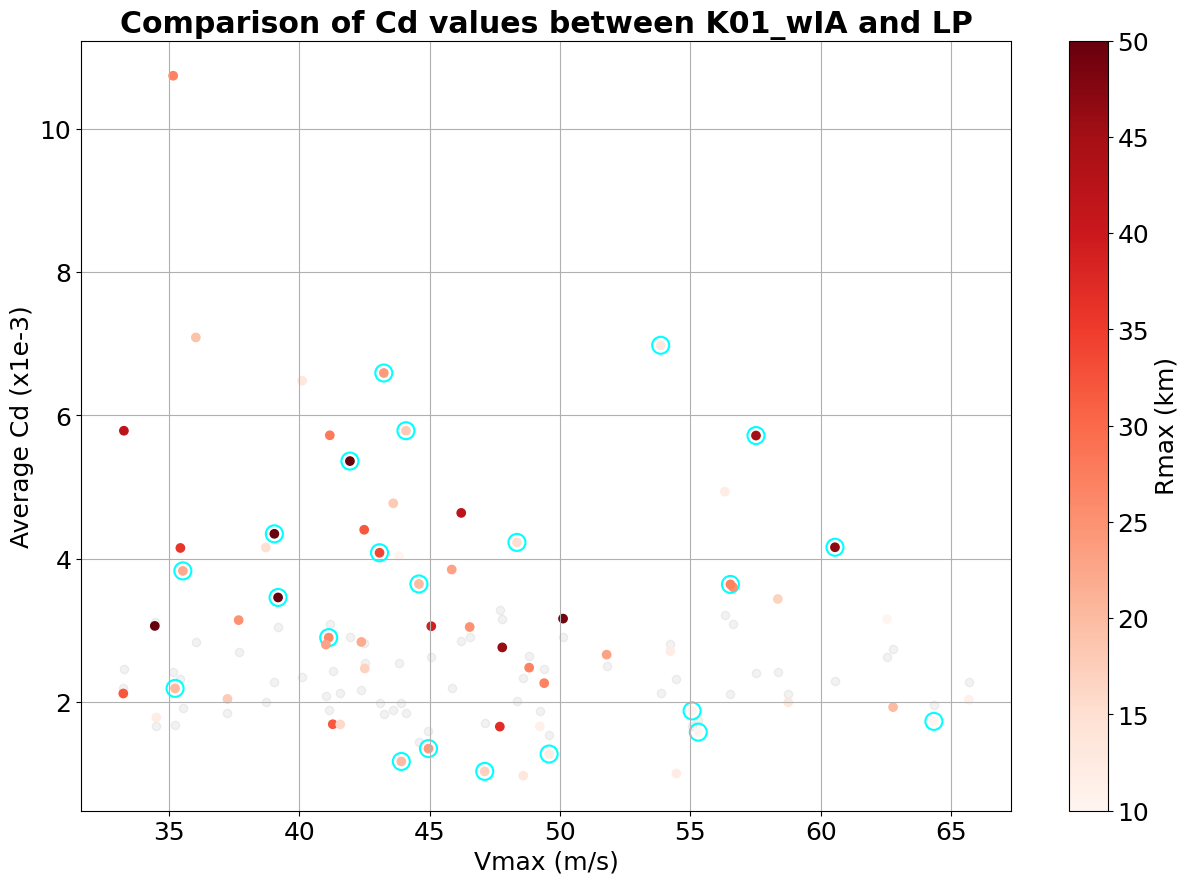

In [265]:
# In Cyan: Non-C1 points
plt.title('Comparison of Cd values between K01_wIA and LP', weight='bold')
plt.scatter(dsm01_wIA.vmx, dsm01_wIA.cd_mean_lp * 1e3, c='gray', alpha=0.1)
plt.scatter(dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True)).vmx, np.sqrt(dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True)).K_mean_kpp) / 1 * dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True)).C_sqrtK_K01 * 1e3, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm01_wIA.vmx, np.sqrt(dsm01_wIA.K_mean_kpp) / 1 * dsm01_wIA.C_sqrtK_K01 * 1e3, c=dsm01_wIA.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
# plt.ylim(0, 10)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

Text(0, 0.5, 'Estimated K (m2/s)')

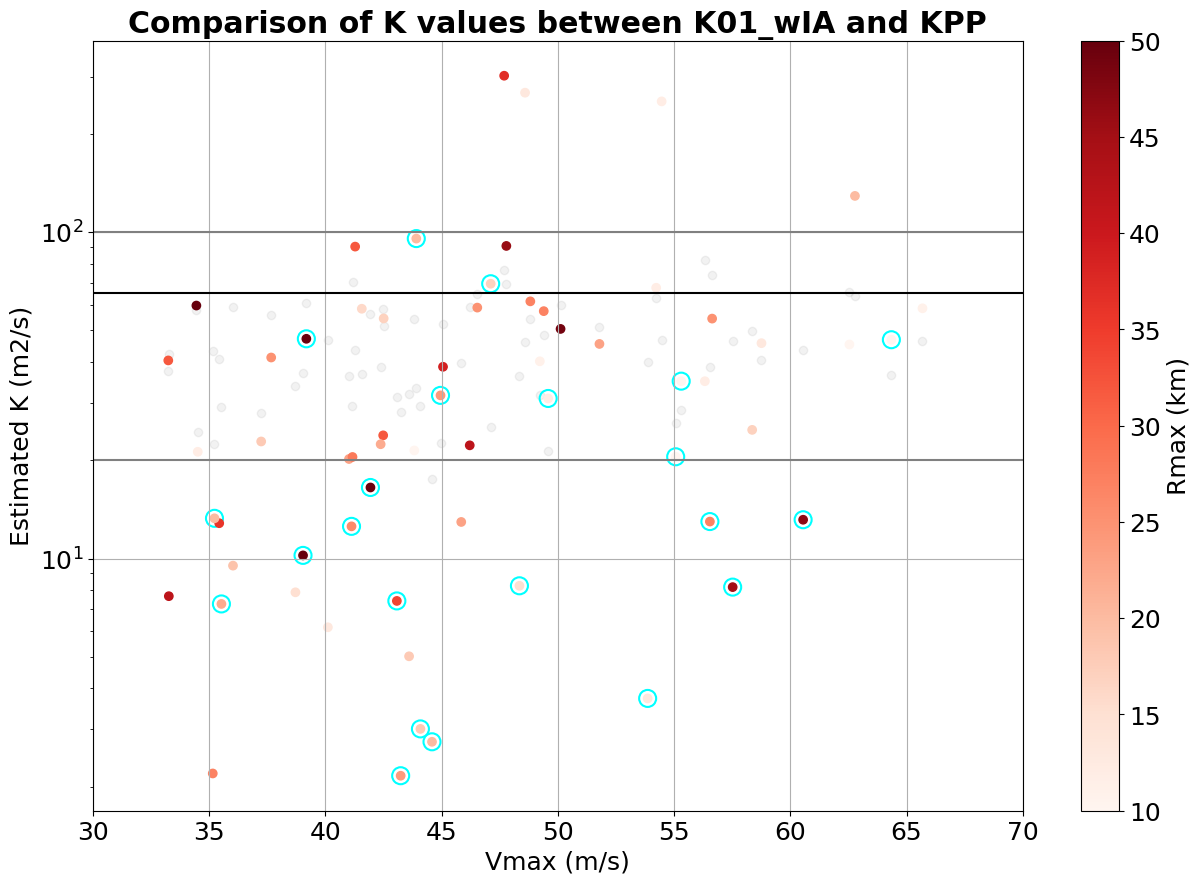

In [266]:
plt.title('Comparison of K values between K01_wIA and KPP', weight='bold')
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
plt.scatter(dsm01_wIA.vmx, dsm01_wIA.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True)).vmx, (dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True)).cd_mean_lp / dsm01_wIA.C_sqrtK_K01) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm01_wIA.vmx, (dsm01_wIA.cd_mean_lp / dsm01_wIA.C_sqrtK_K01) ** 2, c=dsm01_wIA.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
# plt.ylim(-100, 4000)
plt.yscale('log')
# plt.ylim(-10, 200)
plt.xlim(30, 70)
plt.axhline(100, c='gray')
plt.axhline(65,  c='k')
plt.axhline(20,  c='gray')
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Estimated K (m2/s)')

Text(0, 0.5, 'Average Cd from K01_FIT (x1e-3)')

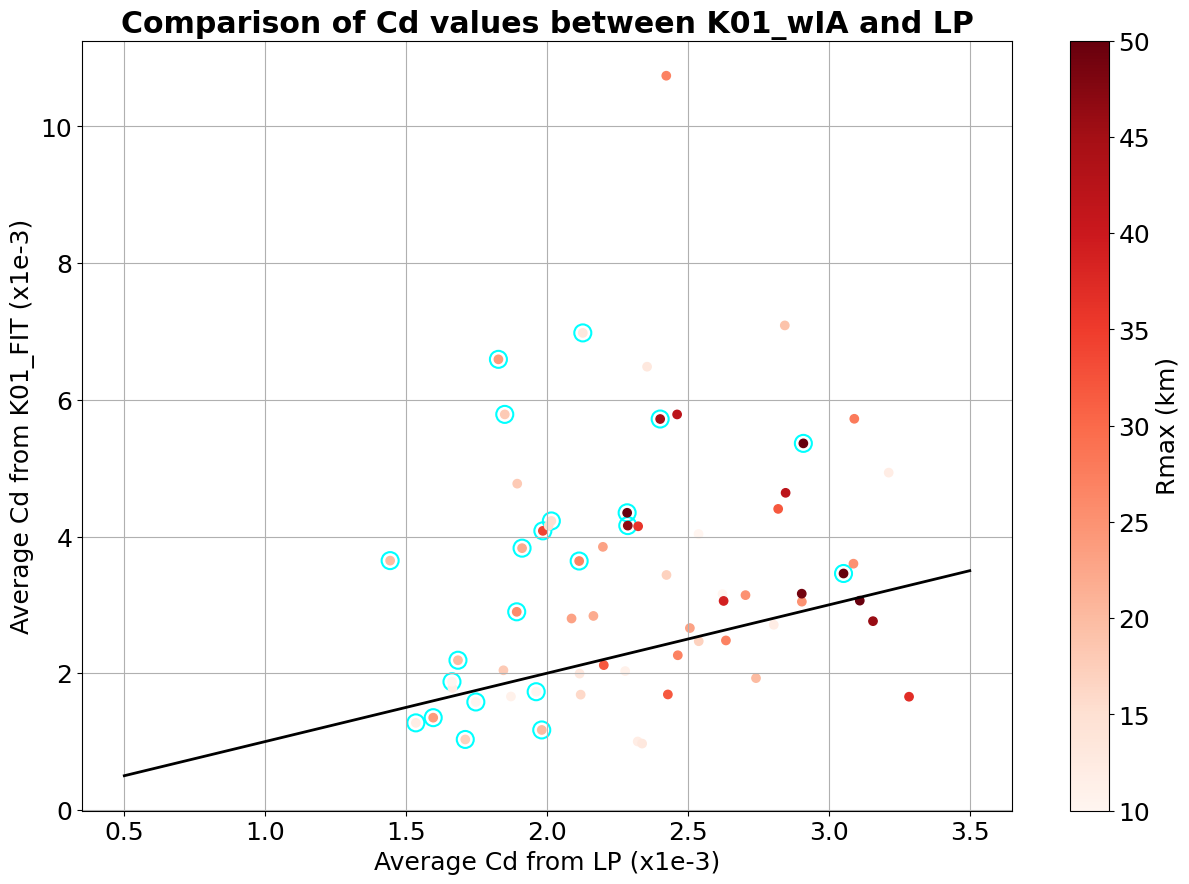

In [267]:
# In Cyan: Non-C1 points
plt.title('Comparison of Cd values between K01_wIA and LP', weight='bold')

plt.scatter(dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True)).cd_mean_lp * 1e3, np.sqrt(dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True)).K_mean_kpp) / 1 * dsm01_wIA.C_sqrtK_K01 * 1e3,  s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm01_wIA.cd_mean_lp * 1e3, np.sqrt(dsm01_wIA.K_mean_kpp) / 1 * dsm01_wIA.C_sqrtK_K01 * 1e3, c=dsm01_wIA.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.plot([0.5, 3.5], [0.5, 3.5], c='k', linewidth=2)
# plt.ylim(0, 4)
plt.grid()
plt.xlabel('Average Cd from LP (x1e-3)')
plt.ylabel('Average Cd from K01_FIT (x1e-3)')

Text(0, 0.5, 'Estimated K from K01_FIT (m2/s)')

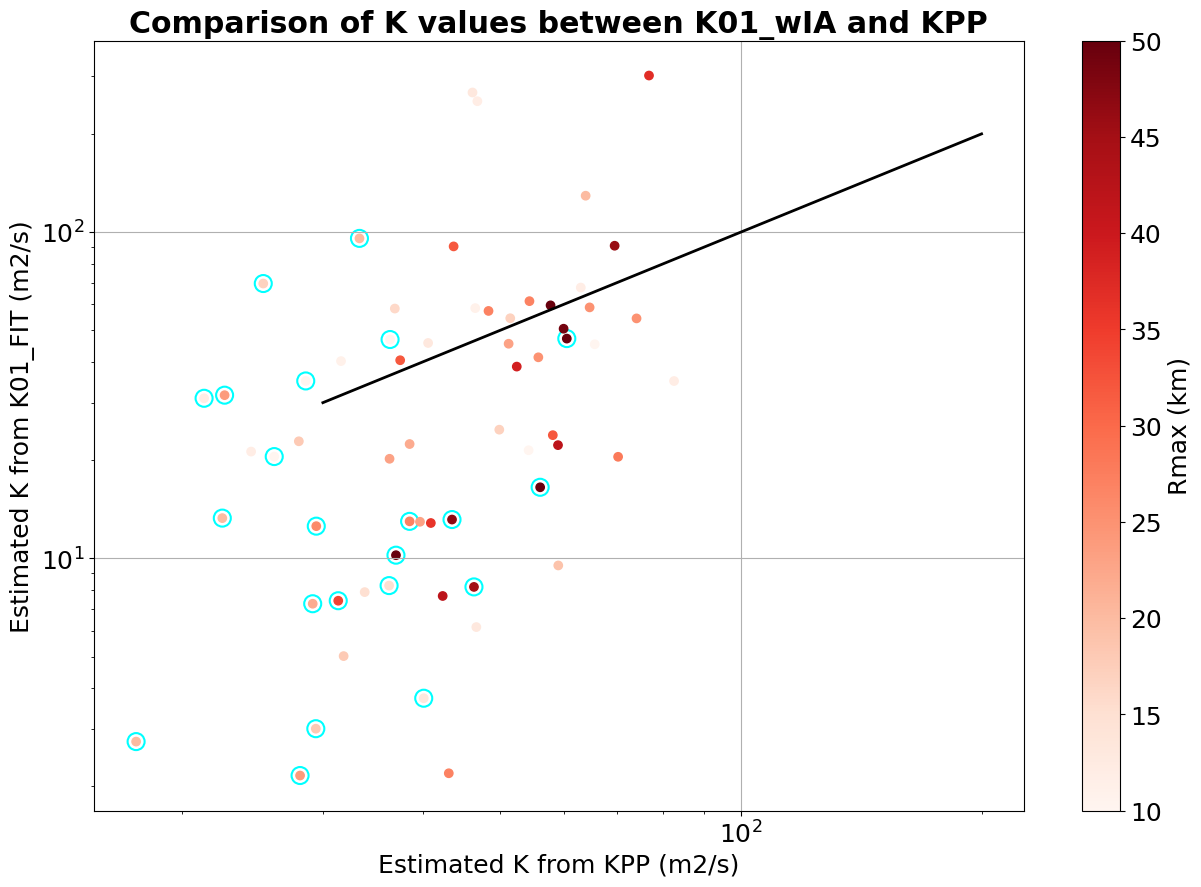

In [270]:
plt.title('Comparison of K values between K01_wIA and KPP', weight='bold')
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
# plt.scatter(dsm01_wIA.vmx, dsm01_wIA.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True)).K_mean_kpp, (dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True)).cd_mean_lp / dsm01_wIA.C_sqrtK_K01) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm01_wIA.K_mean_kpp, (dsm01_wIA.cd_mean_lp / dsm01_wIA.C_sqrtK_K01) ** 2, c=dsm01_wIA.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.xscale('log');plt.yscale('log')
plt.plot([30, 2e2], [30, 2e2], c='k', linewidth=2)
# plt.ylim(1, 500)
plt.grid()
plt.xlabel('Estimated K from KPP (m2/s)')
plt.ylabel('Estimated K from K01_FIT (m2/s)')

Text(0, 0.5, 'Estimated K from K01_FIT (m2/s)')

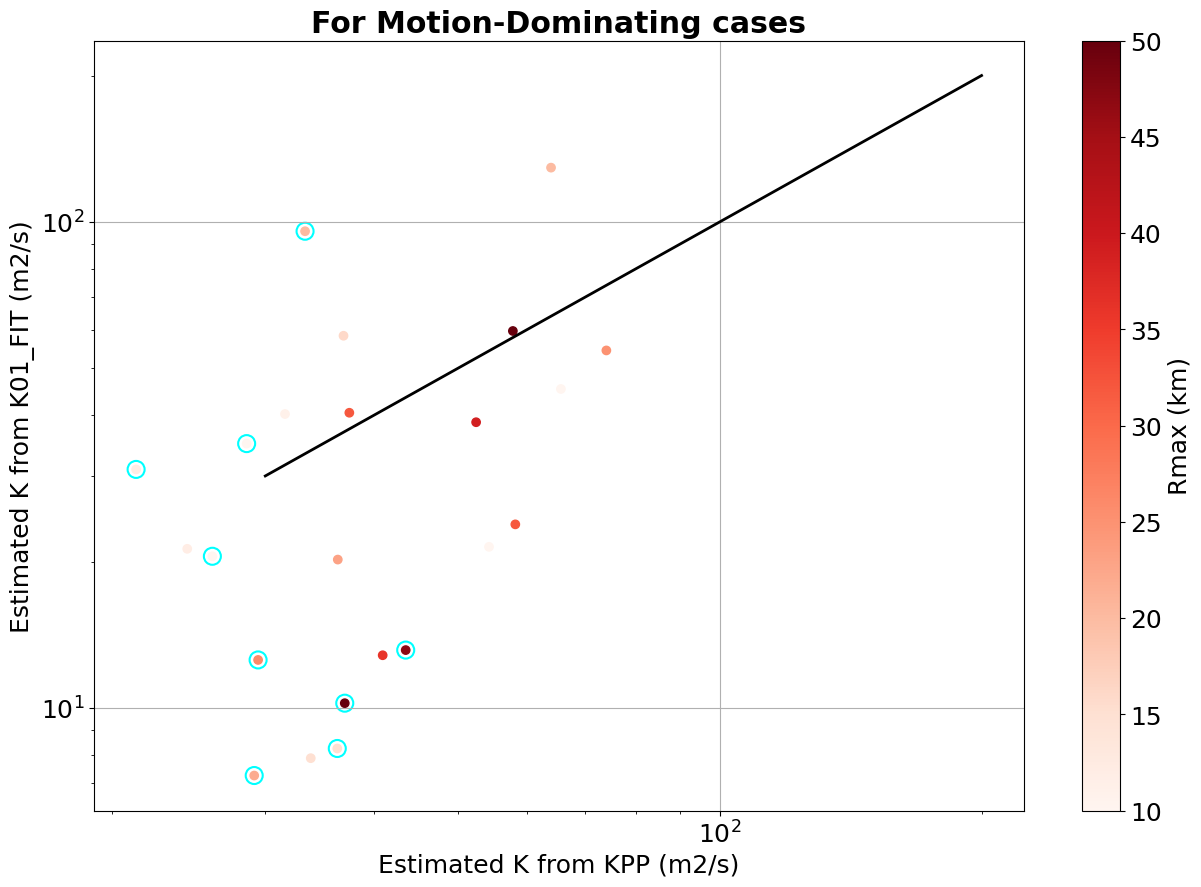

In [271]:
motionDominates = dsm01_wIA.storm_speed_ibt > dsm01_wIA.vws_pmd

plt.title('For Motion-Dominating cases', weight='bold')
# plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
# plt.scatter(dsm01_wIA.vmx, dsm01_wIA.K_mean_kpp, c='gray', alpha=0.1)
plt.scatter(dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True) & motionDominates).K_mean_kpp, (dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True) & motionDominates).cd_mean_lp / dsm01_wIA.C_sqrtK_K01) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsm01_wIA.where(motionDominates).K_mean_kpp, (dsm01_wIA.where(motionDominates).cd_mean_lp / dsm01_wIA.where(motionDominates).C_sqrtK_K01) ** 2, c=dsm01_wIA.where(motionDominates).rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.xscale('log');plt.yscale('log')
plt.plot([30, 2e2], [30, 2e2], c='k', linewidth=2)
# plt.ylim(1, 500)
plt.grid()
plt.xlabel('Estimated K from KPP (m2/s)')
plt.ylabel('Estimated K from K01_FIT (m2/s)')

In [122]:
# ### TEST

# plt.title('K values as a function of Vmax and t_LMI (K01)', weight='bold')
# # plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
# # plt.scatter(dsm01_wIA.vmx, dsm01_wIA.K_mean_kpp, c='gray', alpha=0.1)
# plt.scatter(dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True)).vmx, (dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True)).cd_mean_lp / dsm01_wIA.C_sqrtK_K01) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
# plt.scatter(dsm01_wIA.vmx, (dsm01_wIA.cd_mean_lp / dsm01_wIA.C_sqrtK_K01) ** 2, c=dsm01_wIA.t_since_lmi_ibt / 3600, vmin=-100, vmax=100, cmap=plt.get_cmap('coolwarm', 5))
# plt.colorbar(label='t since LMI (hours)')
# # plt.ylim(-100, 4000)
# plt.yscale('log')
# # plt.ylim(-10, 200)
# plt.xlim(30, 70)
# plt.axhline(100, c='gray')
# plt.axhline(65,  c='k')
# plt.axhline(20,  c='gray')
# plt.grid()
# plt.xlabel('Vmax (m/s)')
# plt.ylabel('Estimated K (m2/s)')

# plt.show()

# plt.title('For Motion-Dominating cases (K25)', weight='bold')
# # plt.scatter(dsm.vmx, 0.1 * dsm.vmx ** 2, c='gray', alpha=0.3)
# # plt.scatter(dsm01_wIA.vmx, dsm01_wIA.K_mean_kpp, c='gray', alpha=0.1)
# plt.scatter(dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True) & motionDominates).vmx, (dsm01_wIA.where(xr.where(dsm01_wIA.non_C1 == 0, False, True) & motionDominates).cd_mean_lp / dsm01_wIA.C_sqrtK_K01) ** 2, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
# plt.scatter(dsm01_wIA.vmx, (dsm01_wIA.where(motionDominates).cd_mean_lp / dsm01_wIA.where(motionDominates).C_sqrtK_K01) ** 2, c=dsm01_wIA.where(motionDominates).t_since_lmi_ibt / 3600, vmin=-100, vmax=100, cmap=plt.get_cmap('coolwarm', 5))
# plt.colorbar(label='t since LMI (hours)')
# # plt.ylim(-100, 4000)
# plt.yscale('log')
# # plt.ylim(-10, 200)
# plt.xlim(30, 70)
# plt.axhline(100, c='gray')
# plt.axhline(65,  c='k')
# plt.axhline(20,  c='gray')
# plt.grid()
# plt.xlabel('Vmax (m/s)')
# plt.ylabel('Estimated K (m2/s)')

#### f) Consistency between K01_wIA and K25_wIA

In [93]:
dsmg_wIA = xr.merge([dsm01_wIA, dsm25_wIA], join="inner", compat='override')
isC1     = xr.where(dsm01_wIA.non_C1 == 0, False, True) & xr.where(dsm25_wIA.non_C1 == 0, False, True)

Text(0, 0.5, 'Average C / sqrt(K) from K25_wIA')

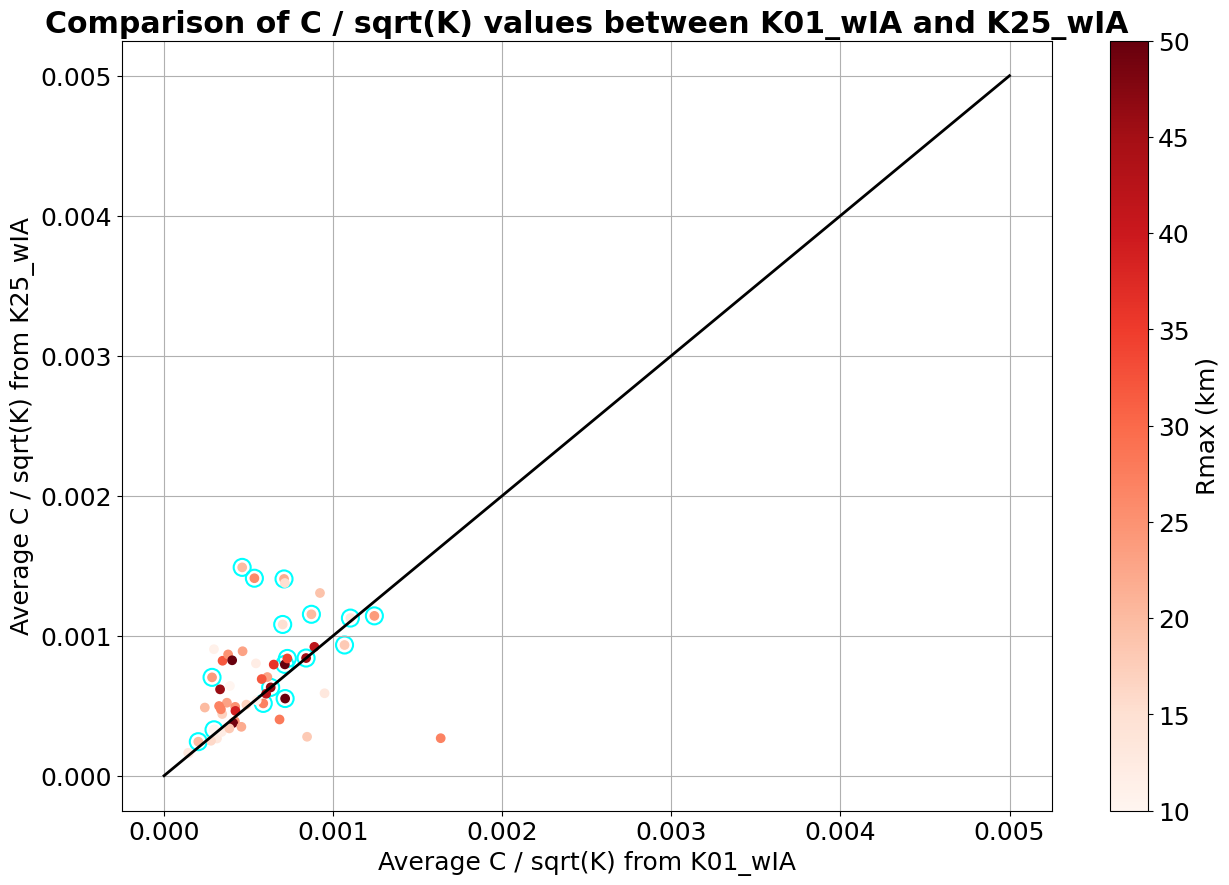

In [94]:
plt.title('Comparison of C / sqrt(K) values between K01_wIA and K25_wIA', weight='bold')
plt.scatter(dsmg_wIA.where(isC1).C_sqrtK_K01, dsmg_wIA.where(isC1).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsmg_wIA.C_sqrtK_K01, dsmg_wIA.C_sqrtK_K25, c=dsmg_wIA.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.plot([0., 0.005], [0., 0.005], c='k', linewidth=2)
# plt.xlim(0, 20);plt.ylim(0, 20)
plt.grid()
plt.xlabel('Average C / sqrt(K) from K01_wIA')
plt.ylabel('Average C / sqrt(K) from K25_wIA')

Text(0, 0.5, 'Average C / sqrt(K) from K25_wIA')

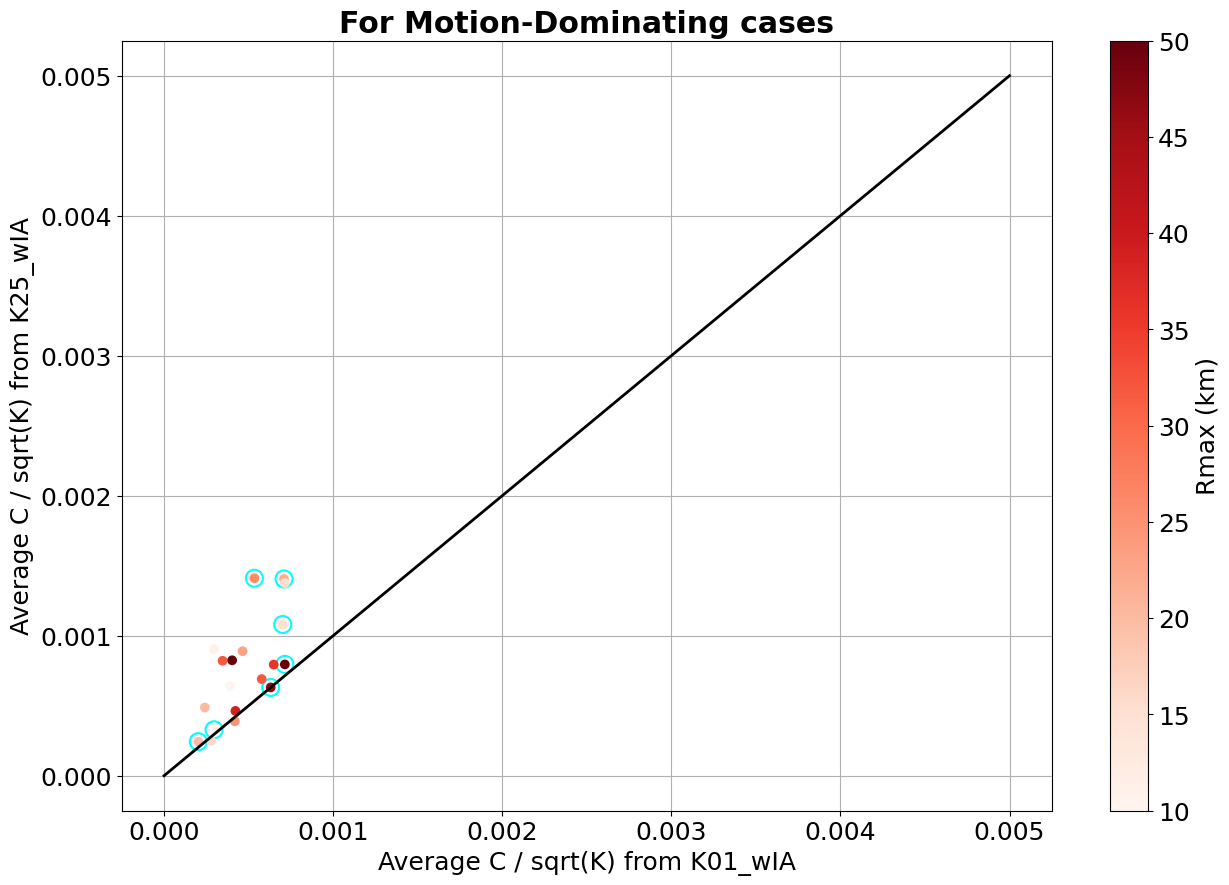

In [95]:
motionDominates = dsmg_wIA.storm_speed_ibt > dsmg_wIA.vws_pmd

plt.title('For Motion-Dominating cases', weight='bold')
plt.scatter(dsmg_wIA.where(motionDominates & isC1).C_sqrtK_K01, dsmg_wIA.where(motionDominates & isC1).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dsmg_wIA.where(motionDominates).C_sqrtK_K01, dsmg_wIA.where(motionDominates).C_sqrtK_K25, c=dsmg_wIA.where(motionDominates).rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar(label='Rmax (km)')
plt.plot([0., 0.005], [0., 0.005], c='k', linewidth=2)
# plt.xlim(0, 20);plt.ylim(0, 20)
plt.grid()
plt.xlabel('Average C / sqrt(K) from K01_wIA')
plt.ylabel('Average C / sqrt(K) from K25_wIA')

On the figure above, for the bottom right outlier, K01 cannot fit well because the surface wind maximum is not 90° right to the motion vector.

For the upper left outlier, K25 does not fit well the scatterometer inflow angle (K01 also struggles), but I don't know why.

In [104]:
# dsmg_wIA.where((dsmg_wIA.where(motionDominates).C_sqrtK_K25 > 0.0007) & (dsmg_wIA.where(motionDominates).C_sqrtK_K01 < 0.0006), drop=True).file_tcva

In [376]:
### TODO: Think about how I tell the story. Cooking recipe (maybe just Zhang and Uhlhorn)?
### TODO: Tune h, bibliography: to obtain realistic results I should divide my KPP values by 4. 

### Grouping cases that have a similar Vmax, B, and Rmax

In [37]:
dkk = dk.where(
    (dk.vmx >= 40) & (dk.vmx <= 50) & (dk.B_hol >= 1.5) & (dk.B_hol <= 2) & (dk. rmx <= 30000)
)

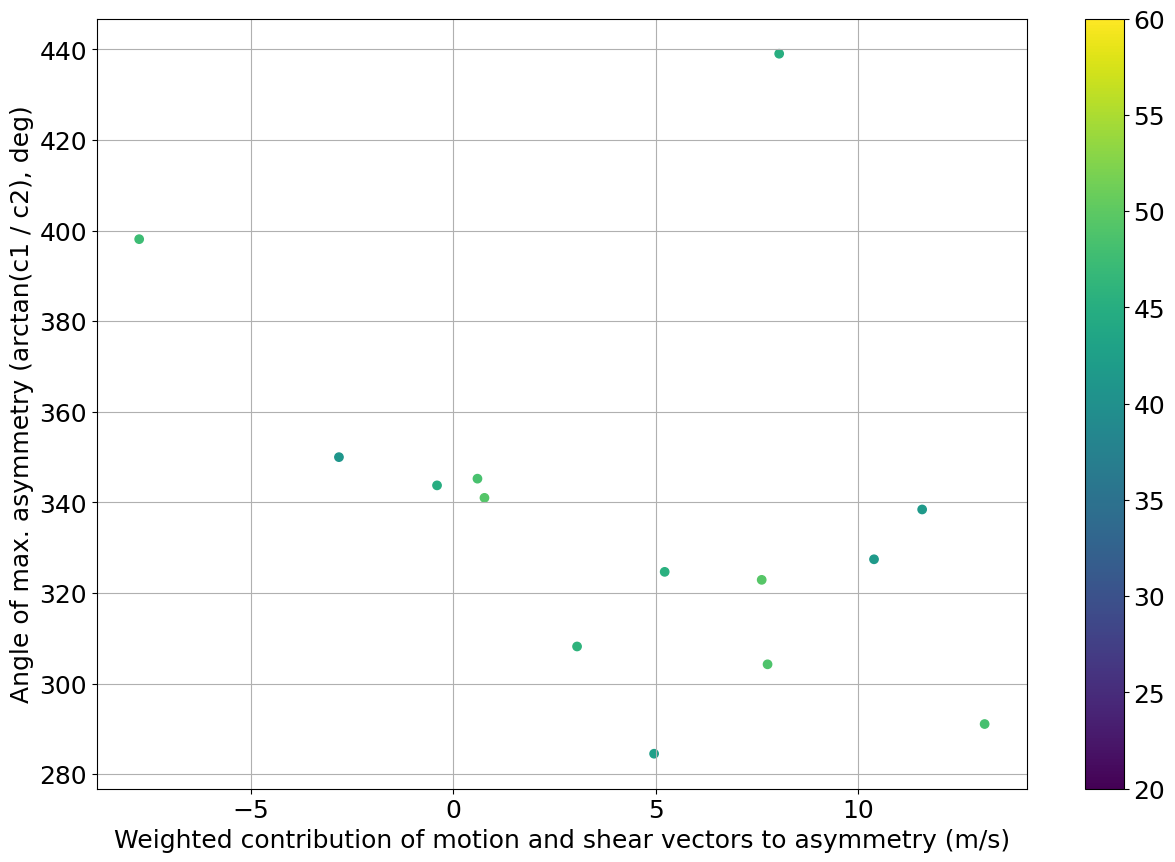

In [38]:
# c1 / c2 as a function of relative contribution from shear and motion vectors
# NB: les outliers en haut semblent normaux
# NB: l'outlier tout à gauche à un Vmax très faible, proche de 20 m/s
plt.scatter(dkk.storm_speed_ibt * np.cos(np.deg2rad(dkk.storm_dir_ibt)) + dkk.vws_pmd * np.cos(np.deg2rad(dkk.wsd_pmd)), angles_bis, c=dkk.vmx, vmin=20, vmax=60)
plt.colorbar()
plt.xlabel('Weighted contribution of motion and shear vectors to asymmetry (m/s)')
plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
plt.grid()

### Estimating (C /sqrt(K), c1, c2) from (Ut, VWS, Holland params)

CAVEAT: I need to consider the cosinus/sinus of the angles.

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [40]:
dk['cos_mtnd'] = np.cos(np.deg2rad(dk.storm_dir_ibt))
dk['sin_mtnd'] = np.sin(np.deg2rad(dk.storm_dir_ibt))
dk['cos_vwsd'] = np.cos(np.deg2rad(dk.wsd_pmd))
dk['sin_vwsd'] = np.sin(np.deg2rad(dk.wsd_pmd))

In [41]:
preds   = ['storm_speed_ibt', 'cos_mtnd', 'sin_mtnd', 'cos_vwsd', 'sin_vwsd', 'vmx', 'rmx', 'B_hol', 'fcor']
targets = ['C_sqrtK_K25', 'c1_K25', 'c2_K25']
dk_reg  = dk[preds + targets].dropna(dim='time', how='any')
dk_df   = dk_reg.to_dataframe()
dk_df['C_sqrtK_K25'] = dk_df['C_sqrtK_K25'] * 1e5

In [42]:
X = dk_df[preds]
y = dk_df[targets]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Taille de l'ensemble d'entraînement (X_train): {X_train.shape}")
print(f"Taille de l'ensemble de test (X_test): {X_test.shape}")
print(f"Taille de l'ensemble d'entraînement (y_train): {y_train.shape}")
print(f"Taille de l'ensemble de test (y_test): {y_test.shape}")

# Initialiser le modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

Taille de l'ensemble d'entraînement (X_train): (69, 9)
Taille de l'ensemble de test (X_test): (18, 9)
Taille de l'ensemble d'entraînement (y_train): (69, 3)
Taille de l'ensemble de test (y_test): (18, 3)


In [44]:
# Puisqu'il s'agit d'une multi-régression (plusieurs variables cibles),
# les métriques seront calculées pour chaque variable cible.

# Coefficients du modèle
print("\nCoefficients du modèle pour chaque variable cible:")
for i, target_name in enumerate(targets):
    print(f"  Pour '{target_name}':")
    for feature, coef in zip(preds, model.coef_[i]):
        print(f"    {feature}: {coef:.4f}")
    print(f"  Intercept (ordonnée à l'origine) pour '{target_name}': {model.intercept_[i]:.4f}")
    print("-" * 30)

# Métriques d'évaluation
print("\nMétriques d'évaluation (RMSE et R-squared) pour chaque variable cible:")
for i, target_name in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_test[target_name], y_pred[:, i]))
    r2 = r2_score(y_test[target_name], y_pred[:, i])
    print(f"  Pour '{target_name}':")
    print(f"    Erreur Quadratique Moyenne (RMSE): {rmse:.4f}")
    print(f"    Coefficient de Détermination (R-squared): {r2:.4f}")
    print("-" * 30)

# Si vous voulez voir un aperçu des prédictions vs. les vraies valeurs
print("\nQuelques exemples de prédictions vs. vraies valeurs (pour les 5 premières entrées de l'ensemble de test):")
for i in range(min(5, len(y_test))):
    print(f"\nExemple {i+1}:")
    for j, target_name in enumerate(targets):
        print(f"  {target_name}: Vrai = {y_test.iloc[i][target_name]:.4f}, Prédit = {y_pred[i, j]:.4f}")



Coefficients du modèle pour chaque variable cible:
  Pour 'C_sqrtK_K25':
    storm_speed_ibt: -0.5004
    cos_mtnd: -4.7315
    sin_mtnd: -9.1132
    cos_vwsd: -12.2851
    sin_vwsd: 2.9954
    vmx: -1.6330
    rmx: -0.0002
    B_hol: -24.8697
    fcor: 440932.3963
  Intercept (ordonnée à l'origine) pour 'C_sqrtK_K25': 125.6156
------------------------------
  Pour 'c1_K25':
    storm_speed_ibt: -0.0013
    cos_mtnd: -0.2193
    sin_mtnd: 0.4288
    cos_vwsd: -0.3925
    sin_vwsd: -0.0420
    vmx: -0.0192
    rmx: -0.0000
    B_hol: -0.1570
    fcor: -9646.7086
  Intercept (ordonnée à l'origine) pour 'c1_K25': 1.5607
------------------------------
  Pour 'c2_K25':
    storm_speed_ibt: 0.1755
    cos_mtnd: -0.5786
    sin_mtnd: -0.0908
    cos_vwsd: -0.1765
    sin_vwsd: 0.0489
    vmx: 0.0278
    rmx: 0.0000
    B_hol: -0.2476
    fcor: 13473.2911
  Intercept (ordonnée à l'origine) pour 'c2_K25': -1.2778
------------------------------

Métriques d'évaluation (RMSE et R-squared) pour c